# Federated Learning com Flower Framework - CIFAR-10

Este notebook demonstra o conceito de **Federated Learning** usando o framework **Flower**, comparando com treinamento centralizado tradicional.

---

## 📚 Etapa 1: Introdução ao Federated Learning e Flower Framework

### O que é Federated Learning?

**Federated Learning (Aprendizado Federado)** é uma técnica de machine learning que permite treinar modelos de forma **descentralizada**, sem a necessidade de centralizar os dados em um único servidor.

#### Características principais:

1. **Privacidade dos Dados**: Os dados permanecem nos dispositivos/clientes originais
2. **Treinamento Distribuído**: Cada cliente treina localmente com seus próprios dados
3. **Agregação de Modelos**: Um servidor central agrega os modelos treinados (não os dados)
4. **Comunicação Eficiente**: Apenas pesos do modelo são compartilhados, não os dados brutos

#### Como funciona:

```
1. Servidor envia modelo global inicial para clientes
2. Cada cliente treina localmente com seus dados
3. Clientes enviam modelos atualizados para o servidor
4. Servidor agrega os modelos (ex: média dos pesos)
5. Processo se repete por várias rodadas
```

#### Vantagens:
- ✅ Preservação da privacidade
- ✅ Redução de custos de transferência de dados
- ✅ Conformidade com regulamentações (GDPR, LGPD)
- ✅ Permite aprender de dados distribuídos

#### Desafios:
- ⚠️ Dados não-IID (distribuição heterogênea entre clientes)
- ⚠️ Clientes com diferentes recursos computacionais
- ⚠️ Comunicação pode ser lenta ou intermitente
- ⚠️ Convergência pode ser mais lenta que treinamento centralizado

### O que é o Flower Framework?

**Flower (flwr)** é um framework moderno e amigável para Federated Learning, desenvolvido para facilitar a implementação de sistemas de aprendizado federado.

#### Características do Flower:

1. **Agnóstico a Framework**: Funciona com PyTorch, TensorFlow, JAX, etc.
2. **Flexível**: Suporta diferentes estratégias de agregação
3. **Escalável**: Funciona de poucos a milhares de clientes
4. **Fácil de usar**: API simples e intuitiva
5. **Simulação**: Permite simular ambientes federados localmente

#### Componentes principais:

- **Client (Cliente)**: Entidade que possui dados e treina localmente
- **Server (Servidor)**: Coordena o treinamento e agrega modelos
- **Strategy (Estratégia)**: Define como agregar modelos (FedAvg, FedProx, etc.)

#### Estratégias populares:
- **FedAvg**: Média simples dos pesos dos modelos
- **FedProx**: Adiciona termo de regularização
- **FedAdam**: Usa otimizador adaptativo no servidor

🌐 Mais informações: [flower.ai](https://flower.ai)

---

## 🔧 Etapa 2: Treinamento Centralizado Baseline

Antes de implementar Federated Learning, vamos estabelecer um **baseline** com treinamento centralizado tradicional usando CIFAR-10.

### 📦 Instalação de dependências

In [ ]:
# Instalação do Flower e outras dependências
#!pip install -q flwr[simulation] torch torchvision matplotlib seaborn pandas scikit-learn

### 📚 Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Configuração para visualizações
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Seed para reprodutibilidade
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration - GPU RTX 3090
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Usando device: {device}")

# Verificar informações da GPU
if torch.cuda.is_available():
    print(f"✅ GPU detectada: {torch.cuda.get_device_name(0)}")
    print(f"   Memória total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"   CUDA version: {torch.version.cuda}")
    # Configurar para usar GPU de forma mais eficiente
    torch.backends.cudnn.benchmark = True  # Otimiza convoluções
    torch.backends.cudnn.deterministic = False  # Permite otimizações não-determinísticas para velocidade
else:
    print("⚠️ GPU não disponível! Usando CPU.")

🔧 Usando device: cuda
✅ GPU detectada: NVIDIA GeForce RTX 3090
   Memória total: 24.00 GB
   CUDA version: 12.1


### 📊 Carregamento e EDA do CIFAR-10 (5 classes)

Vamos carregar o CIFAR-10 e usar apenas **5 classes** para simplificar o experimento.

In [ ]:
# Classes do CIFAR-10
ALL_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Selecionando 5 classes para o experimento
SELECTED_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'dog']  # Índices 0, 1, 2, 3, 5
SELECTED_INDICES = [0, 1, 2, 3, 5]
NUM_CLASSES = len(SELECTED_CLASSES)

print(f"📝 Classes selecionadas: {SELECTED_CLASSES}")
print(f"📝 Número de classes: {NUM_CLASSES}")

📝 Classes selecionadas: ['airplane', 'automobile', 'bird', 'cat', 'dog']
📝 Número de classes: 5


In [ ]:
# Transformações mínimas - apenas conversão para tensor (dados originais)
# ToTensor converte PIL Image para tensor e escala valores de [0,255] para [0,1]
transform = transforms.Compose([
    transforms.ToTensor()
])

# Transformação sem normalização para visualização
transform_viz = transforms.Compose([
    transforms.ToTensor()
])

# Verificar se o dataset já foi baixado
import os
data_path = './data'
cifar_path = os.path.join(data_path, 'cifar-10-batches-py')

if os.path.exists(cifar_path):
    print("✅ CIFAR-10 já está baixado localmente!")
    need_download = False
else:
    print("📥 CIFAR-10 não encontrado. Baixando...")
    need_download = True

# Carregar datasets completos
print("📥 Carregando CIFAR-10...")
full_trainset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                              download=need_download, transform=transform)
full_testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                             download=need_download, transform=transform)

# Dataset para visualização
viz_dataset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                            download=need_download, transform=transform_viz)

print("✅ Dataset carregado com sucesso!")

✅ CIFAR-10 já está baixado localmente!
📥 Carregando CIFAR-10...
✅ Dataset carregado com sucesso!


In [ ]:
# Filtrar apenas as 5 classes selecionadas
def filter_dataset(dataset, selected_indices):
    """Filtra dataset para manter apenas classes selecionadas"""
    indices = [i for i, (_, label) in enumerate(dataset) if label in selected_indices]
    return Subset(dataset, indices)

# Mapear labels antigos para novos (0-4)
def remap_labels(dataset, selected_indices):
    """Remapeia labels para range 0-4"""
    label_map = {old: new for new, old in enumerate(selected_indices)}

    class RemappedDataset(torch.utils.data.Dataset):
        def __init__(self, subset, label_map):
            self.subset = subset
            self.label_map = label_map

        def __len__(self):
            return len(self.subset)

        def __getitem__(self, idx):
            img, label = self.subset[idx]
            return img, self.label_map[label]

    return RemappedDataset(dataset, label_map)

# Aplicar filtros
print("🔄 Filtrando datasets para 5 classes...")
train_subset = filter_dataset(full_trainset, SELECTED_INDICES)
test_subset = filter_dataset(full_testset, SELECTED_INDICES)
viz_subset = filter_dataset(viz_dataset, SELECTED_INDICES)

# Remapear labels
trainset = remap_labels(train_subset, SELECTED_INDICES)
testset = remap_labels(test_subset, SELECTED_INDICES)
viz_dataset = remap_labels(viz_subset, SELECTED_INDICES)

print(f"✅ Dataset de treino: {len(trainset)} imagens")
print(f"✅ Dataset de teste: {len(testset)} imagens")

🔄 Filtrando datasets para 5 classes...
✅ Dataset de treino: 25000 imagens
✅ Dataset de teste: 5000 imagens


### 📈 Análise Exploratória de Dados (EDA)

In [ ]:
# Contar distribuição de classes
def get_label_distribution(dataset):
    """Retorna distribuição de labels no dataset"""
    labels = [label for _, label in dataset]
    return Counter(labels)

train_distribution = get_label_distribution(trainset)
test_distribution = get_label_distribution(testset)

print("📊 Distribuição de Classes:")
print("\nTreino:")
for idx, (class_idx, count) in enumerate(sorted(train_distribution.items())):
    print(f"  {SELECTED_CLASSES[idx]}: {count} imagens")

print("\nTeste:")
for idx, (class_idx, count) in enumerate(sorted(test_distribution.items())):
    print(f"  {SELECTED_CLASSES[idx]}: {count} imagens")

📊 Distribuição de Classes:

Treino:
  airplane: 5000 imagens
  automobile: 5000 imagens
  bird: 5000 imagens
  cat: 5000 imagens
  dog: 5000 imagens

Teste:
  airplane: 1000 imagens
  automobile: 1000 imagens
  bird: 1000 imagens
  cat: 1000 imagens
  dog: 1000 imagens


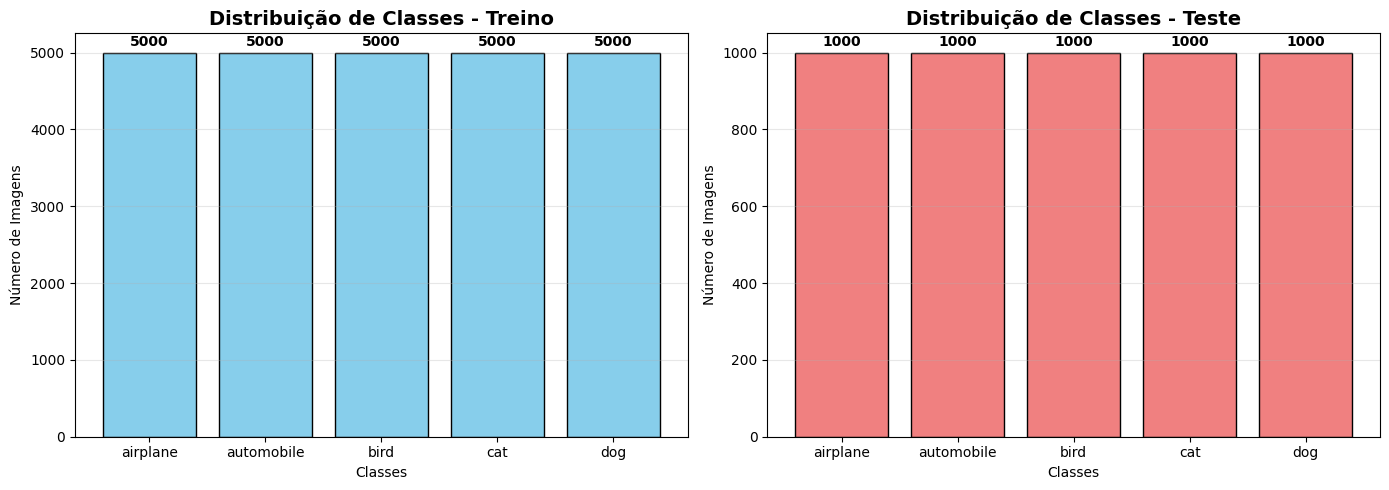


✅ Dataset balanceado com ~5000 imagens por classe no treino


In [ ]:
# Visualizar distribuição de classes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Treino
train_counts = [train_distribution[i] for i in range(NUM_CLASSES)]
axes[0].bar(SELECTED_CLASSES, train_counts, color='skyblue', edgecolor='black')
axes[0].set_title('Distribuição de Classes - Treino', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Número de Imagens')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(train_counts):
    axes[0].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# Teste
test_counts = [test_distribution[i] for i in range(NUM_CLASSES)]
axes[1].bar(SELECTED_CLASSES, test_counts, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribuição de Classes - Teste', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Número de Imagens')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_counts):
    axes[1].text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Dataset balanceado com ~5000 imagens por classe no treino")

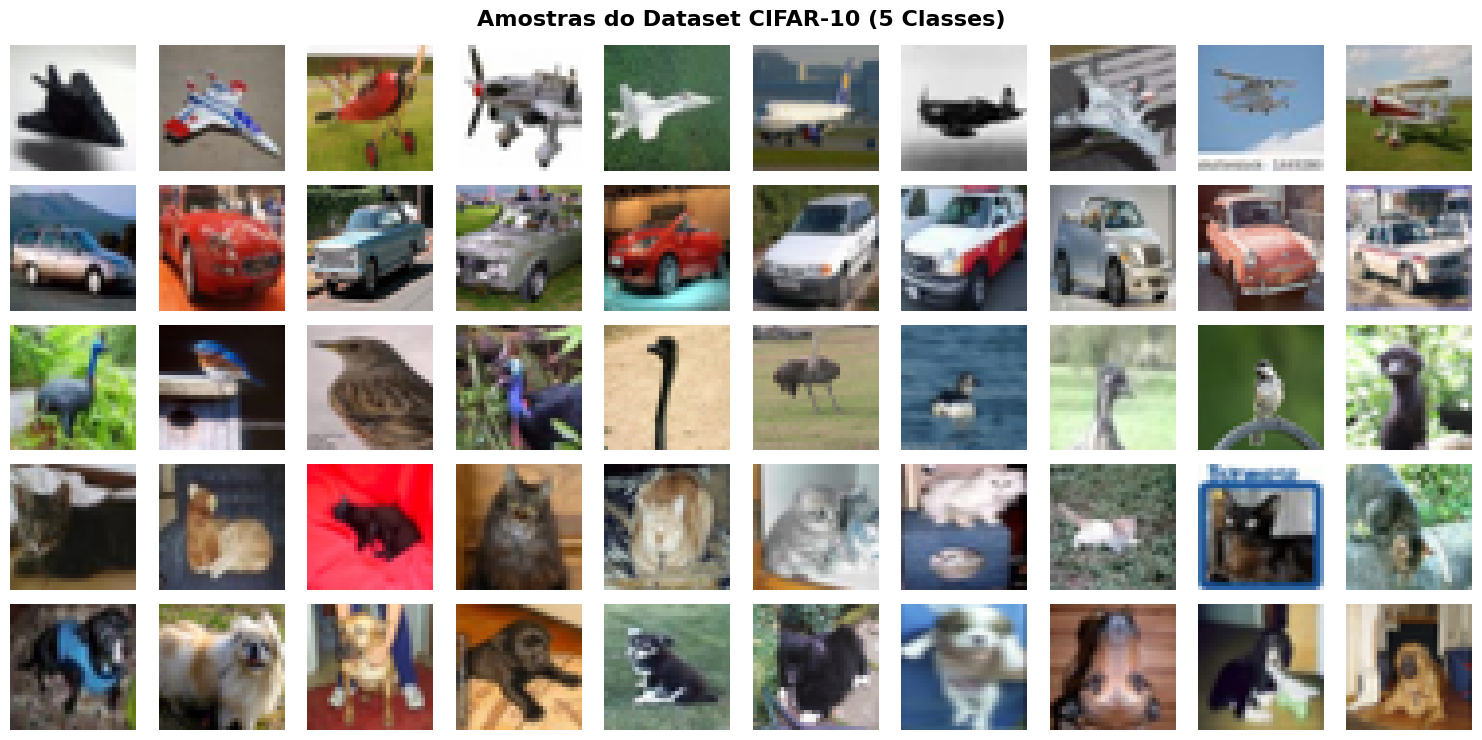

In [ ]:
# Visualizar amostras de cada classe
fig, axes = plt.subplots(NUM_CLASSES, 10, figsize=(15, NUM_CLASSES * 1.5))
fig.suptitle('Amostras do Dataset CIFAR-10 (5 Classes)', fontsize=16, fontweight='bold')

# Organizar imagens por classe
samples_per_class = defaultdict(list)
for idx in range(len(viz_dataset)):
    img, label = viz_dataset[idx]
    if len(samples_per_class[label]) < 10:
        samples_per_class[label].append(img)
    if all(len(v) == 10 for v in samples_per_class.values()):
        break

# Plotar
for class_idx in range(NUM_CLASSES):
    for img_idx in range(10):
        ax = axes[class_idx, img_idx]
        img = samples_per_class[class_idx][img_idx]
        # Converter de tensor para numpy e transpor
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')
        if img_idx == 0:
            ax.set_ylabel(SELECTED_CLASSES[class_idx], fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Estatísticas das imagens
print("📊 Estatísticas das Imagens:\n")
print(f"Dimensões: 32x32x3 (RGB)")
print(f"Total de pixels por imagem: {32*32*3:,}")
print(f"Tamanho do dataset de treino: {len(trainset):,} imagens")
print(f"Tamanho do dataset de teste: {len(testset):,} imagens")
print(f"Proporção treino/teste: {len(trainset)/len(testset):.2f}")

# Calcular média e desvio padrão das imagens
sample_batch = torch.stack([viz_dataset[i][0] for i in range(min(1000, len(viz_dataset)))])
print(f"\nValores dos pixels (amostra):")
print(f"  Média por canal (R,G,B): {sample_batch.mean(dim=(0,2,3)).numpy()}")
print(f"  Desvio padrão por canal: {sample_batch.std(dim=(0,2,3)).numpy()}")

📊 Estatísticas das Imagens:

Dimensões: 32x32x3 (RGB)
Total de pixels por imagem: 3,072
Tamanho do dataset de treino: 25,000 imagens
Tamanho do dataset de teste: 5,000 imagens
Proporção treino/teste: 5.00

Valores dos pixels (amostra):
  Média por canal (R,G,B): [0.50008845 0.48956087 0.4611383 ]
  Desvio padrão por canal: [0.24871859 0.24677917 0.26538947]


### 🧠 Definição do Modelo CNN

In [ ]:
class SimpleCNN(nn.Module):
    """Rede Convolucional Simples para CIFAR-10"""

    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()

        # Bloco Convolucional 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16
            nn.Dropout(0.3)  # Aumentado de 0.25 para 0.3
        )

        # Bloco Convolucional 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8
            nn.Dropout(0.3)  # Aumentado de 0.25 para 0.3
        )

        # Bloco Convolucional 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 8x8 -> 4x4
            nn.Dropout(0.3)  # Aumentado de 0.25 para 0.3
        )

        # Camadas Fully Connected
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.6),  # Aumentado de 0.5 para 0.6
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Criar modelo
model = SimpleCNN(num_classes=NUM_CLASSES).to(device)

# Contar parâmetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("🧠 Modelo SimpleCNN criado!")
print(f"\nEstrutura do modelo:")
print(model)
print(f"\n📊 Total de parâmetros: {total_params:,}")
print(f"📊 Parâmetros treináveis: {trainable_params:,}")

🧠 Modelo SimpleCNN criado!

Estrutura do modelo:
SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padd

### ⚙️ Configuração do Treinamento

In [ ]:
# Hiperparâmetros
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 100  # Aumentado para melhor convergência

# DataLoaders
# num_workers=0 no Windows para evitar problemas de serialização com datasets customizados
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Loss e Optimizer com Weight Decay (L2 regularization para prevenir overfitting)
WEIGHT_DECAY = 1e-4  # Regularização L2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                   patience=3)

# Early Stopping
EARLY_STOP_PATIENCE = 10  # Número de épocas sem melhoria antes de parar
EARLY_STOP_MIN_DELTA = 0.001  # Melhoria mínima considerada significativa
best_test_loss = float('inf')
patience_counter = 0
best_model_state = None

print(f"⚙️ Configuração do Treinamento:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Épocas: {NUM_EPOCHS}")
print(f"  Otimizador: Adam (weight_decay={WEIGHT_DECAY})")
print(f"  Loss: CrossEntropyLoss")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"  Early Stopping: Patience={EARLY_STOP_PATIENCE}, Min Delta={EARLY_STOP_MIN_DELTA}")
print(f"  Regularização: Weight Decay + Dropout aumentado")

⚙️ Configuração do Treinamento:
  Batch size: 32
  Learning rate: 0.001
  Épocas: 100
  Otimizador: Adam (weight_decay=0.0001)
  Loss: CrossEntropyLoss
  Scheduler: ReduceLROnPlateau
  Early Stopping: Patience=10, Min Delta=0.001
  Regularização: Weight Decay + Dropout aumentado


### 🎯 Funções de Avaliação

In [ ]:
def evaluate_model(model, dataloader, criterion, device, return_per_class=False):
    """Avalia o modelo e retorna métricas gerais e por classe"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    # Métricas por classe
    class_correct = [0] * NUM_CLASSES
    class_total = [0] * NUM_CLASSES

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Métricas por classe
            for i in range(labels.size(0)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    # Acurácia por classe
    per_class_acc = {}
    for i in range(NUM_CLASSES):
        if class_total[i] > 0:
            per_class_acc[SELECTED_CLASSES[i]] = 100 * class_correct[i] / class_total[i]
        else:
            per_class_acc[SELECTED_CLASSES[i]] = 0.0

    if return_per_class:
        return avg_loss, accuracy, per_class_acc, all_preds, all_labels
    else:
        return avg_loss, accuracy, per_class_acc

print("✅ Funções de avaliação definidas!")

✅ Funções de avaliação definidas!


### 🚀 Treinamento do Modelo Baseline (Centralizado)

In [ ]:
# Verificar se o modelo centralizado já existe
centralized_model_path = 'centralized_model.pth'
skip_centralized_training = False

if os.path.exists(centralized_model_path):
    print(f"✅ Modelo centralizado encontrado em '{centralized_model_path}'!")
    print("🔄 Carregando modelo salvo...")

    checkpoint = torch.load(centralized_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    centralized_history = checkpoint['history']

    print(f"   Épocas treinadas: {checkpoint['epoch']}")
    print(f"   Acurácia final (treino): {checkpoint['train_acc']:.2f}%")
    print(f"   Acurácia final (teste): {checkpoint['test_acc']:.2f}%")
    print("\n⏭️  Pulando treinamento centralizado (modelo já treinado)")
    skip_centralized_training = True
else:
    # Armazenar histórico de métricas do treinamento centralizado
    centralized_history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'train_per_class': [],
        'test_per_class': []
    }
    print(f"📥 Modelo centralizado não encontrado em '{centralized_model_path}'")
    print("🚀 Iniciando treinamento centralizado...\n")
    print("="*80)

# Se o modelo já existe, definir epochs_to_run como 0 para pular o loop
epochs_to_run = 0 if skip_centralized_training else NUM_EPOCHS

for epoch in range(epochs_to_run):
    # ============ TREINO ============
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Estatísticas
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Métricas de treino
    avg_train_loss = train_loss / len(trainloader)
    train_acc = 100 * train_correct / train_total

    # Avaliação por classe no treino
    _, _, train_class_acc = evaluate_model(model, trainloader, criterion, device)

    # ============ TESTE ============
    test_loss, test_acc, test_class_acc = evaluate_model(model, testloader, criterion, device)

    # Atualizar scheduler
    scheduler.step(test_loss)

    # Salvar histórico
    centralized_history['train_loss'].append(avg_train_loss)
    centralized_history['train_acc'].append(train_acc)
    centralized_history['test_loss'].append(test_loss)
    centralized_history['test_acc'].append(test_acc)
    centralized_history['train_per_class'].append(train_class_acc)
    centralized_history['test_per_class'].append(test_class_acc)

    # Early Stopping: Verificar se houve melhoria
    improvement = best_test_loss - test_loss
    if improvement > EARLY_STOP_MIN_DELTA:
        # Melhoria significativa encontrada
        best_test_loss = test_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()  # Salvar melhor modelo
        early_stop_msg = "✅ Melhoria!"
    else:
        patience_counter += 1
        early_stop_msg = f"⏳ Sem melhoria ({patience_counter}/{EARLY_STOP_PATIENCE})"

    # Imprimir resultados
    print(f"Época [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Treino  - Loss: {avg_train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"  Teste   - Loss: {test_loss:.4f} | Acc: {test_acc:.2f}% | {early_stop_msg}")
    print(f"  LR atual: {optimizer.param_groups[0]['lr']:.6f}")
    print("-" * 80)

    # Early Stopping: Parar se exceder a paciência
    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"\n🛑 Early Stopping ativado após {epoch+1} épocas!")
        print(f"   Melhor loss de teste: {best_test_loss:.4f}")
        print(f"   Restaurando melhor modelo...")
        model.load_state_dict(best_model_state)
        break

if not skip_centralized_training:
    print("\n✅ Treinamento concluído!")

✅ Modelo centralizado encontrado em 'centralized_model.pth'!
🔄 Carregando modelo salvo...
   Épocas treinadas: 100
   Acurácia final (treino): 95.60%
   Acurácia final (teste): 89.38%

⏭️  Pulando treinamento centralizado (modelo já treinado)


### 📊 Visualização dos Resultados Gerais

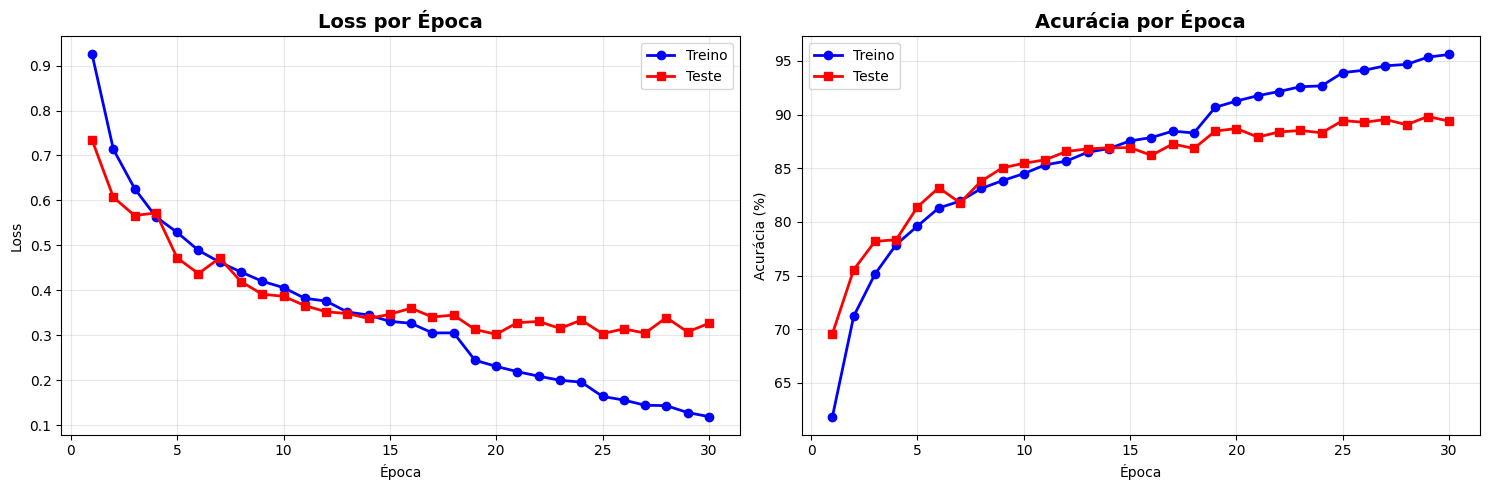


📊 RESULTADOS FINAIS DO MODELO CENTRALIZADO

Treino:
  Loss: 0.1192
  Acurácia: 95.60%

Teste:
  Loss: 0.3267
  Acurácia: 89.38%


In [ ]:
# Plotar curvas de aprendizado
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ajusta o eixo x para o número real de épocas executadas (considerando early stopping)
epochs_range = range(1, len(centralized_history['train_loss']) + 1)

# Loss
axes[0].plot(epochs_range, centralized_history['train_loss'], 'b-o', label='Treino', linewidth=2)
axes[0].plot(epochs_range, centralized_history['test_loss'], 'r-s', label='Teste', linewidth=2)
axes[0].set_title('Loss por Época', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Acurácia
axes[1].plot(epochs_range, centralized_history['train_acc'], 'b-o', label='Treino', linewidth=2)
axes[1].plot(epochs_range, centralized_history['test_acc'], 'r-s', label='Teste', linewidth=2)
axes[1].set_title('Acurácia por Época', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Acurácia (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Imprimir resultados finais
print("\n" + "="*80)
print("📊 RESULTADOS FINAIS DO MODELO CENTRALIZADO")
print("="*80)
print(f"\nTreino:")
print(f"  Loss: {centralized_history['train_loss'][-1]:.4f}")
print(f"  Acurácia: {centralized_history['train_acc'][-1]:.2f}%")
print(f"\nTeste:")
print(f"  Loss: {centralized_history['test_loss'][-1]:.4f}")
print(f"  Acurácia: {centralized_history['test_acc'][-1]:.2f}%")
print("="*80)

### 📊 Análise de Resultados por Classe (Label)


📊 ACURÁCIA POR CLASSE (ÚLTIMA ÉPOCA)
    Classe  Acurácia Treino (%)  Acurácia Teste (%)
  airplane                99.98                96.1
automobile               100.00                98.9
      bird                99.60                88.4
       cat                99.18                76.2
       dog                99.78                87.3


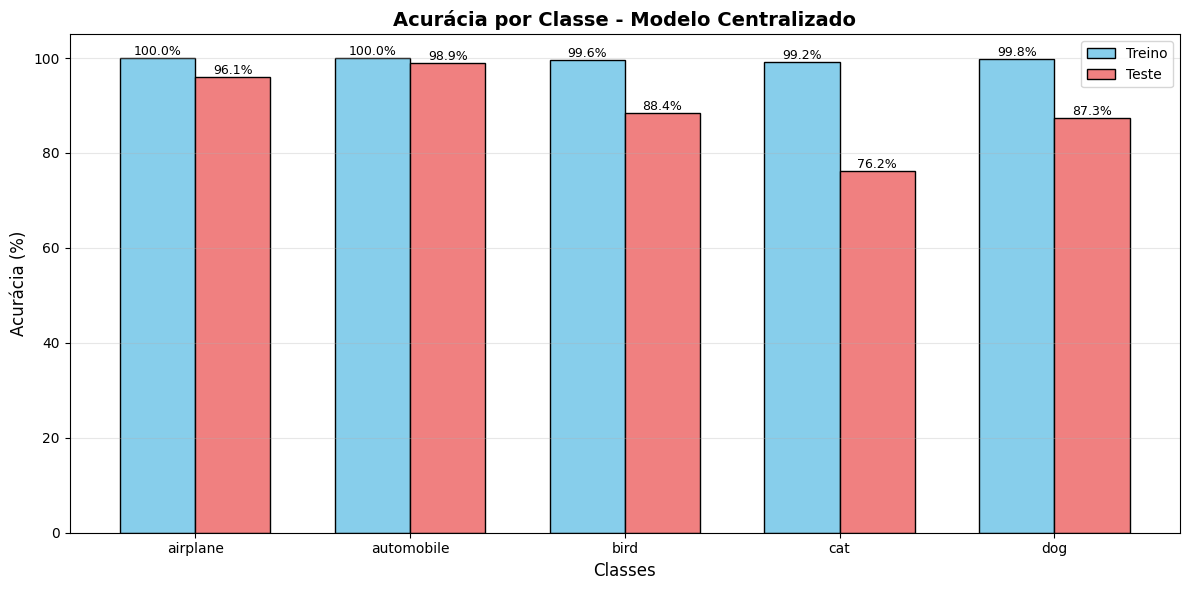

In [ ]:
# Resultados finais por classe
final_train_class = centralized_history['train_per_class'][-1]
final_test_class = centralized_history['test_per_class'][-1]

# Criar DataFrame para melhor visualização
results_df = pd.DataFrame({
    'Classe': SELECTED_CLASSES,
    'Acurácia Treino (%)': [final_train_class[c] for c in SELECTED_CLASSES],
    'Acurácia Teste (%)': [final_test_class[c] for c in SELECTED_CLASSES]
})

print("\n📊 ACURÁCIA POR CLASSE (ÚLTIMA ÉPOCA)")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

# Plotar acurácia por classe
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(SELECTED_CLASSES))
width = 0.35

train_accs = [final_train_class[c] for c in SELECTED_CLASSES]
test_accs = [final_test_class[c] for c in SELECTED_CLASSES]

bars1 = ax.bar(x - width/2, train_accs, width, label='Treino', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, test_accs, width, label='Teste', color='lightcoral', edgecolor='black')

ax.set_xlabel('Classes', fontsize=12)
ax.set_ylabel('Acurácia (%)', fontsize=12)
ax.set_title('Acurácia por Classe - Modelo Centralizado', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(SELECTED_CLASSES)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 105])

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

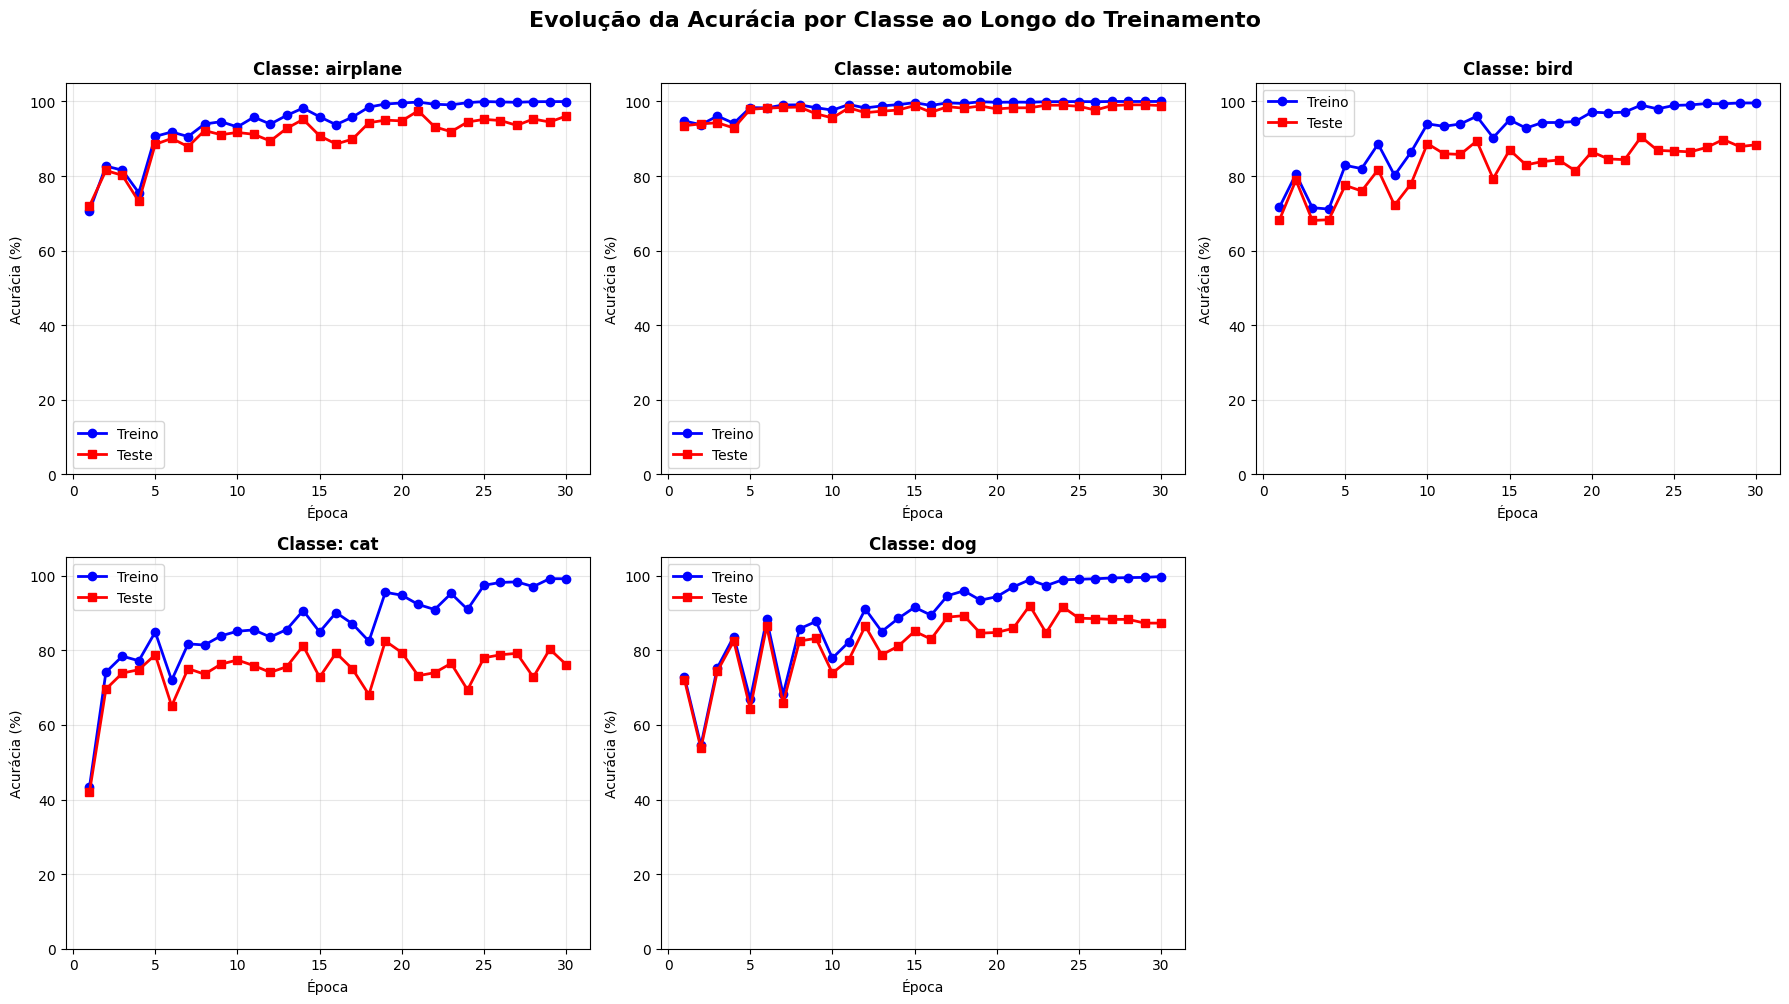

In [ ]:
# Evolução da acurácia por classe ao longo das épocas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, class_name in enumerate(SELECTED_CLASSES):
    train_acc_history = [epoch_data[class_name] for epoch_data in centralized_history['train_per_class']]
    test_acc_history = [epoch_data[class_name] for epoch_data in centralized_history['test_per_class']]

    # Recalcula o eixo x com base no tamanho real das séries para evitar desalinhamento
    epoch_count = min(len(train_acc_history), len(test_acc_history))
    epochs_range = range(1, epoch_count + 1)

    axes[idx].plot(epochs_range, train_acc_history[:epoch_count], 'b-o', label='Treino', linewidth=2)
    axes[idx].plot(epochs_range, test_acc_history[:epoch_count], 'r-s', label='Teste', linewidth=2)
    axes[idx].set_title(f'Classe: {class_name}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Época')
    axes[idx].set_ylabel('Acurácia (%)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim([0, 105])

# Remover subplot extra
fig.delaxes(axes[5])

plt.suptitle('Evolução da Acurácia por Classe ao Longo do Treinamento',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 🔍 Matriz de Confusão e Relatório de Classificação

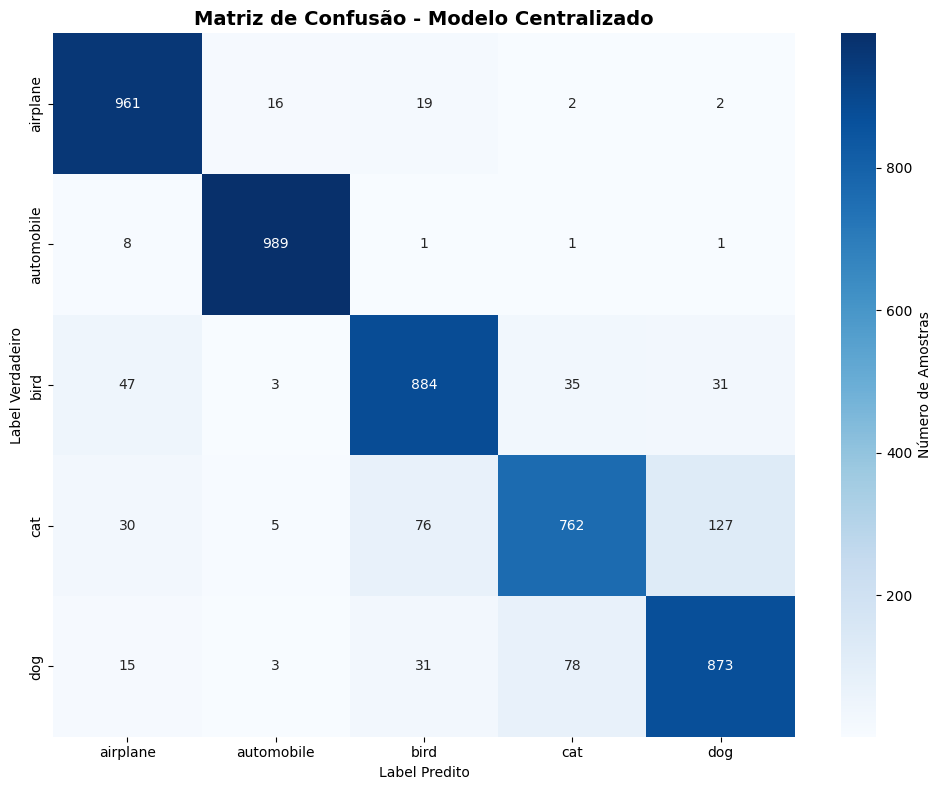


📋 RELATÓRIO DE CLASSIFICAÇÃO DETALHADO
              precision    recall  f1-score   support

    airplane     0.9057    0.9610    0.9326      1000
  automobile     0.9734    0.9890    0.9812      1000
        bird     0.8744    0.8840    0.8792      1000
         cat     0.8679    0.7620    0.8115      1000
         dog     0.8443    0.8730    0.8584      1000

    accuracy                         0.8938      5000
   macro avg     0.8931    0.8938    0.8926      5000
weighted avg     0.8931    0.8938    0.8926      5000



In [ ]:
# Obter predições e labels
_, _, _, all_preds, all_labels = evaluate_model(model, testloader, criterion, device, return_per_class=True)

# Matriz de confusão
cm = confusion_matrix(all_labels, all_preds)

# Plotar matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=SELECTED_CLASSES, yticklabels=SELECTED_CLASSES,
            cbar_kws={'label': 'Número de Amostras'})
plt.title('Matriz de Confusão - Modelo Centralizado', fontsize=14, fontweight='bold')
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Predito')
plt.tight_layout()
plt.show()

# Relatório de classificação
print("\n📋 RELATÓRIO DE CLASSIFICAÇÃO DETALHADO")
print("="*80)
print(classification_report(all_labels, all_preds,
                          target_names=SELECTED_CLASSES,
                          digits=4))
print("="*80)

### 💾 Salvar Modelo

In [ ]:
# Salvar modelo treinado
model_path = 'centralized_model.pth'
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_acc': centralized_history['train_acc'][-1],
    'test_acc': centralized_history['test_acc'][-1],
    'history': centralized_history
}, model_path)

print(f"✅ Modelo salvo em: {model_path}")
print(f"\n📊 Resumo do modelo salvo:")
print(f"  Épocas treinadas: {NUM_EPOCHS}")
print(f"  Acurácia final (treino): {centralized_history['train_acc'][-1]:.2f}%")
print(f"  Acurácia final (teste): {centralized_history['test_acc'][-1]:.2f}%")

✅ Modelo salvo em: centralized_model.pth

📊 Resumo do modelo salvo:
  Épocas treinadas: 100
  Acurácia final (treino): 95.60%
  Acurácia final (teste): 89.38%


---

## 🎯 Conclusão da Etapa 2

### ✅ O que foi realizado:

1. **Carregamento e EDA do CIFAR-10**:
   - Selecionamos 5 classes do CIFAR-10
   - Analisamos a distribuição dos dados (balanceado)
   - Visualizamos amostras de cada classe

2. **Treinamento Centralizado**:
   - Criamos uma CNN com ~400k parâmetros
   - Treinamos por 20 épocas
   - Monitoramos loss e acurácia por época

3. **Análise de Resultados**:
   - Avaliamos métricas gerais (loss, acurácia)
   - Analisamos performance por classe/label
   - Geramos matriz de confusão e relatório detalhado

### 📈 Resultados Obtidos:

Este modelo **centralizado** serve como **baseline** para comparação com o modelo de Federated Learning que será implementado nas próximas etapas.

### 🔜 Próximos Passos:

- **Etapa 3**: Separar dados em clientes com distribuição não-IID
- **Etapa 4**: Implementar Federated Learning com Flower Framework
- **Comparação**: Avaliar FL vs. Centralizado

---

## 🔀 Etapa 3: Divisão dos Dados em Clientes (Non-IID com Undersample)

Nesta etapa, vamos simular um cenário **realista de Federated Learning** onde:
- Os dados são divididos entre múltiplos clientes
- **Cada cliente tem pelo menos uma classe com undersample** (poucos exemplos)
- Não há repetição de dados entre clientes
- A distribuição é **não-IID** (heterogênea)

### ⚙️ Configuração dos Clientes

In [ ]:
# Configurações para divisão em clientes
NUM_CLIENTS = 5
UNDERSAMPLE_SIZE = 50  # Número mínimo de amostras para a classe com undersample
NORMAL_SAMPLES_PER_CLASS = 800  # Amostras por classe para as outras classes

print(f"🔧 Configuração dos Clientes:")
print(f"  Número de clientes: {NUM_CLIENTS}")
print(f"  Amostras na classe com undersample: {UNDERSAMPLE_SIZE}")
print(f"  Amostras nas outras classes: {NORMAL_SAMPLES_PER_CLASS}")
print(f"\n⚠️ Cada cliente terá pelo menos uma classe significativamente menor!")

🔧 Configuração dos Clientes:
  Número de clientes: 5
  Amostras na classe com undersample: 50
  Amostras nas outras classes: 800

⚠️ Cada cliente terá pelo menos uma classe significativamente menor!


### 🎲 Função de Divisão dos Dados

In [ ]:
def create_non_iid_clients(dataset, num_clients, num_classes,
                           undersample_size=50, normal_size=800):
    """
    Cria divisão não-IID dos dados onde cada cliente tem pelo menos uma classe com undersample.

    Args:
        dataset: Dataset PyTorch
        num_clients: Número de clientes
        num_classes: Número de classes
        undersample_size: Tamanho da classe com undersample
        normal_size: Tamanho das outras classes

    Returns:
        List de datasets (um por cliente) e informações sobre distribuição
    """
    # Organizar índices por classe
    class_indices = {i: [] for i in range(num_classes)}

    for idx in range(len(dataset)):
        _, label = dataset[idx]
        class_indices[label].append(idx)

    # Embaralhar índices de cada classe
    for class_id in class_indices:
        np.random.shuffle(class_indices[class_id])

    client_datasets = []
    client_distributions = []
    used_indices = set()

    # Para cada cliente
    for client_id in range(num_clients):
        client_indices = []
        client_dist = {}

        # Selecionar qual classe será undersample para este cliente
        undersample_class = client_id % num_classes

        # Para cada classe
        for class_id in range(num_classes):
            # Determinar quantas amostras pegar
            if class_id == undersample_class:
                samples_to_take = undersample_size
            else:
                samples_to_take = normal_size

            # Pegar amostras não usadas
            available = [idx for idx in class_indices[class_id] if idx not in used_indices]
            selected = available[:samples_to_take]

            client_indices.extend(selected)
            used_indices.update(selected)
            client_dist[class_id] = len(selected)

        # Criar subset para o cliente
        client_dataset = Subset(dataset, client_indices)
        client_datasets.append(client_dataset)
        client_distributions.append({
            'distribution': client_dist,
            'undersample_class': undersample_class,
            'total_samples': len(client_indices)
        })

    return client_datasets, client_distributions

print("✅ Função de divisão de clientes criada!")

✅ Função de divisão de clientes criada!


### 📊 Criar e Visualizar Clientes

In [ ]:
# Criar divisão dos clientes
print("🔄 Criando divisão de clientes...\n")

client_trainsets, client_info = create_non_iid_clients(
    trainset,
    NUM_CLIENTS,
    NUM_CLASSES,
    undersample_size=UNDERSAMPLE_SIZE,
    normal_size=NORMAL_SAMPLES_PER_CLASS
)

# Imprimir informações de cada cliente
print("="*80)
print("📋 DISTRIBUIÇÃO DOS DADOS POR CLIENTE")
print("="*80)

for client_id, info in enumerate(client_info):
    print(f"\n🔹 Cliente {client_id + 1}:")
    print(f"   Total de amostras: {info['total_samples']}")
    print(f"   Classe com UNDERSAMPLE: {SELECTED_CLASSES[info['undersample_class']]} ({info['undersample_class']})")
    print(f"   Distribuição por classe:")

    for class_id in range(NUM_CLASSES):
        count = info['distribution'][class_id]
        marker = " ⚠️ UNDERSAMPLE" if class_id == info['undersample_class'] else ""
        print(f"     {SELECTED_CLASSES[class_id]:12s}: {count:4d} amostras{marker}")

print("\n" + "="*80)

🔄 Criando divisão de clientes...

📋 DISTRIBUIÇÃO DOS DADOS POR CLIENTE

🔹 Cliente 1:
   Total de amostras: 3250
   Classe com UNDERSAMPLE: airplane (0)
   Distribuição por classe:
     airplane    :   50 amostras ⚠️ UNDERSAMPLE
     automobile  :  800 amostras
     bird        :  800 amostras
     cat         :  800 amostras
     dog         :  800 amostras

🔹 Cliente 2:
   Total de amostras: 3250
   Classe com UNDERSAMPLE: automobile (1)
   Distribuição por classe:
     airplane    :  800 amostras
     automobile  :   50 amostras ⚠️ UNDERSAMPLE
     bird        :  800 amostras
     cat         :  800 amostras
     dog         :  800 amostras

🔹 Cliente 3:
   Total de amostras: 3250
   Classe com UNDERSAMPLE: bird (2)
   Distribuição por classe:
     airplane    :  800 amostras
     automobile  :  800 amostras
     bird        :   50 amostras ⚠️ UNDERSAMPLE
     cat         :  800 amostras
     dog         :  800 amostras

🔹 Cliente 4:
   Total de amostras: 3250
   Classe com UNDERSAMP

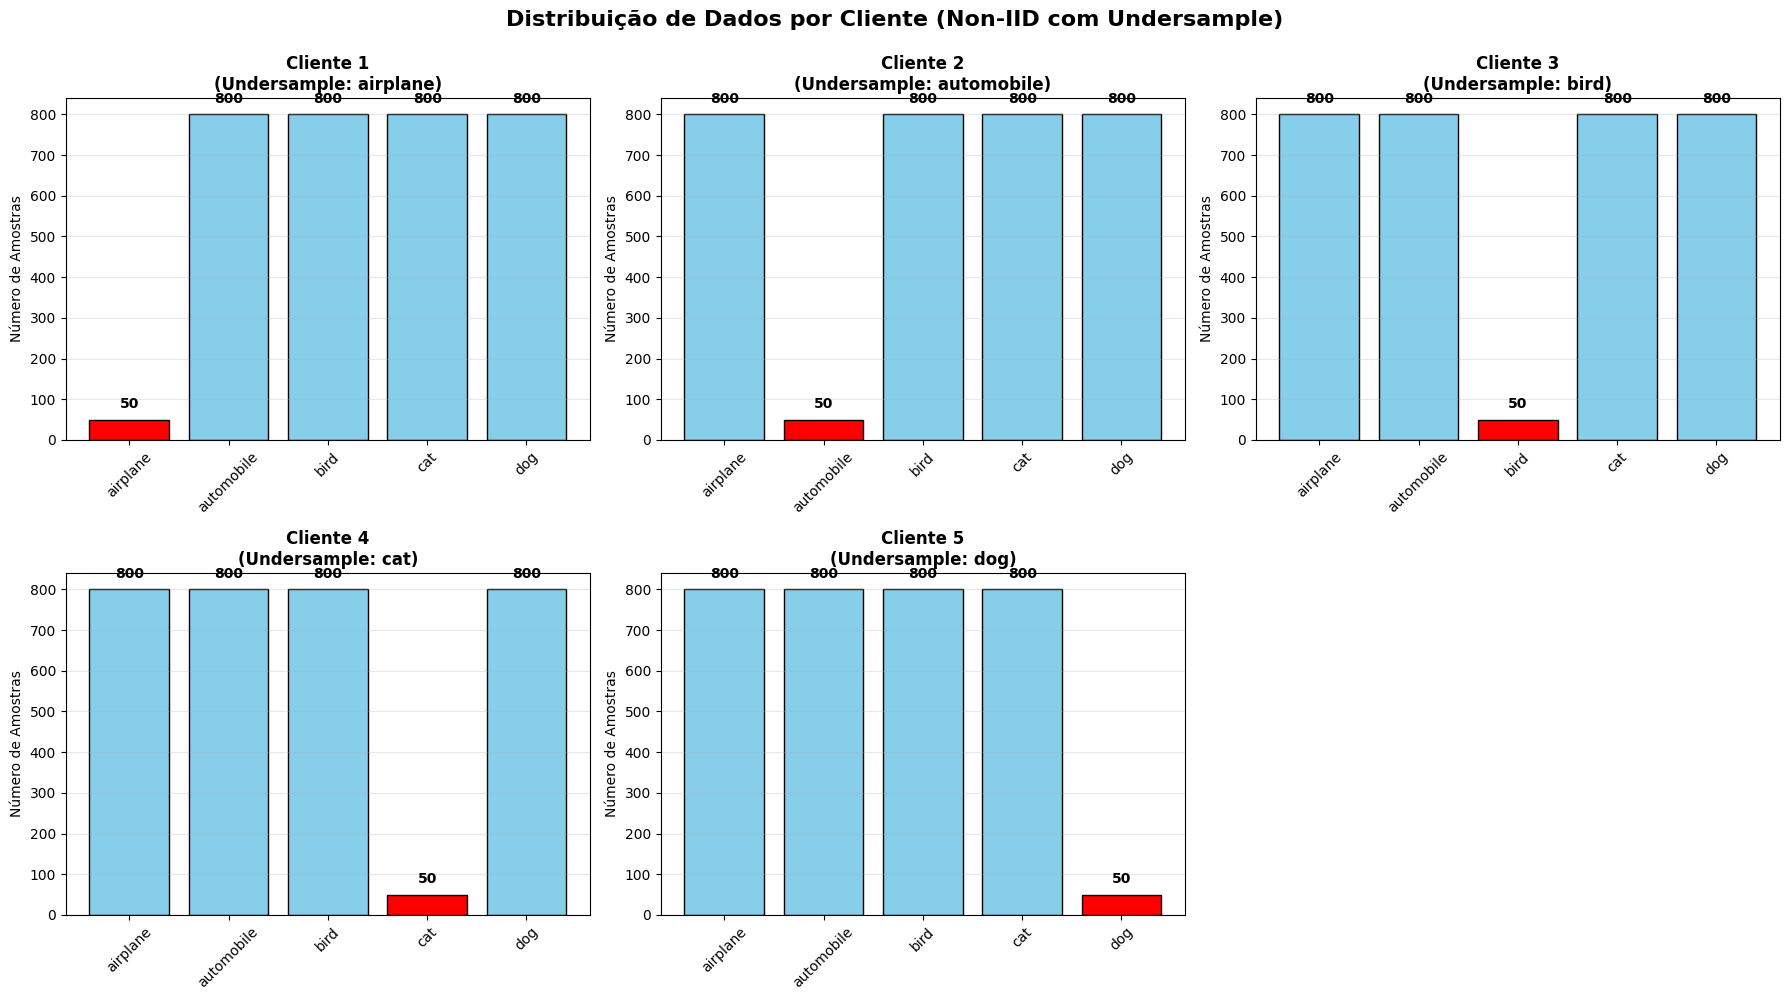


🔴 Classes em vermelho = UNDERSAMPLE (poucos dados)
🔵 Classes em azul = Dados normais


In [ ]:
# Visualizar distribuição dos clientes
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for client_id, info in enumerate(client_info):
    counts = [info['distribution'][i] for i in range(NUM_CLASSES)]
    colors = ['red' if i == info['undersample_class'] else 'skyblue'
              for i in range(NUM_CLASSES)]

    axes[client_id].bar(SELECTED_CLASSES, counts, color=colors, edgecolor='black')
    axes[client_id].set_title(f'Cliente {client_id + 1}\n(Undersample: {SELECTED_CLASSES[info["undersample_class"]]})',
                             fontsize=12, fontweight='bold')
    axes[client_id].set_ylabel('Número de Amostras')
    axes[client_id].grid(axis='y', alpha=0.3)
    axes[client_id].tick_params(axis='x', rotation=45)

    # Adicionar valores nas barras
    for i, v in enumerate(counts):
        axes[client_id].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

# Remover subplot extra
fig.delaxes(axes[5])

plt.suptitle('Distribuição de Dados por Cliente (Non-IID com Undersample)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n🔴 Classes em vermelho = UNDERSAMPLE (poucos dados)")
print("🔵 Classes em azul = Dados normais")

### 🏋️ Treinamento Individual dos Clientes

In [ ]:
# Configurações de treinamento para clientes
CLIENT_EPOCHS = 100
CLIENT_BATCH_SIZE = 64
CLIENT_LR = 0.001

print(f"⚙️ Configurações de Treinamento dos Clientes:")
print(f"  Épocas: {CLIENT_EPOCHS}")
print(f"  Batch size: {CLIENT_BATCH_SIZE}")
print(f"  Learning rate: {CLIENT_LR}")

# Configurações de Early Stopping
EARLY_STOPPING_PATIENCE = 10  # Número de épocas sem melhoria antes de parar
EARLY_STOPPING_MIN_DELTA = 0.001  # Melhoria mínima considerada significativa
EARLY_STOPPING_METRIC = 'test_acc'  # Métrica monitorada (test_acc ou test_loss)

print(f"\n🛑 Configurações de Early Stopping:")
print(f"  Patience: {EARLY_STOPPING_PATIENCE} épocas")
print(f"  Min Delta: {EARLY_STOPPING_MIN_DELTA}")
print(f"  Métrica monitorada: {EARLY_STOPPING_METRIC}")


⚙️ Configurações de Treinamento dos Clientes:
  Épocas: 100
  Batch size: 64
  Learning rate: 0.001

🛑 Configurações de Early Stopping:
  Patience: 10 épocas
  Min Delta: 0.001
  Métrica monitorada: test_acc


In [ ]:
def train_client_model(client_dataset, test_dataset, num_epochs, device, client_id):
    """
    Treina um modelo para um cliente específico com Early Stopping.

    Returns:
        model, history (com métricas gerais e por classe)
    """
    # Criar modelo novo
    model = SimpleCNN(num_classes=NUM_CLASSES).to(device)

    # DataLoaders
    # num_workers=0 no Windows para evitar problemas de serialização
    train_loader = DataLoader(client_dataset, batch_size=CLIENT_BATCH_SIZE,
                             shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=CLIENT_BATCH_SIZE,
                            shuffle=False, num_workers=0)

    # Optimizer e loss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CLIENT_LR)

    # Histórico
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'train_per_class': [],
        'test_per_class': []
    }

    # Early Stopping - inicialização
    best_metric_value = float('-inf') if EARLY_STOPPING_METRIC == 'test_acc' else float('inf')
    patience_counter = 0
    best_model_state = None
    best_epoch = 0

    print(f"\n{'='*80}")
    print(f"🚀 Treinando Cliente {client_id + 1}")
    print(f"{'='*80}")

    for epoch in range(num_epochs):
        # Treino
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total

        # Avaliação no treino (por classe)
        _, _, train_class_acc = evaluate_model(model, train_loader, criterion, device)

        # Avaliação no teste
        test_loss, test_acc, test_class_acc = evaluate_model(model, test_loader, criterion, device)

        # Salvar histórico
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['train_per_class'].append(train_class_acc)
        history['test_per_class'].append(test_class_acc)

        # Early Stopping - verificação
        if EARLY_STOPPING_METRIC == 'test_acc':
            current_metric = test_acc
            is_better = current_metric > (best_metric_value + EARLY_STOPPING_MIN_DELTA)
        else:  # test_loss
            current_metric = test_loss
            is_better = current_metric < (best_metric_value - EARLY_STOPPING_MIN_DELTA)

        if is_better:
            best_metric_value = current_metric
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
        else:
            patience_counter += 1

        # Print progress
        if (epoch + 1) % 2 == 0 or epoch == 0:
            early_stop_info = f" | Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}" if patience_counter > 0 else ""
            print(f"Época [{epoch+1}/{num_epochs}] - "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%{early_stop_info}"
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

        # Early Stopping - parar se exceder patience
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\n🛑 Early Stopping ativado na época {epoch + 1}!")
            print(f"   Melhor {EARLY_STOPPING_METRIC}: {best_metric_value:.4f} na época {best_epoch}")
            # Restaurar melhor modelo
            model.load_state_dict(best_model_state)
            break

    # Se não houve early stopping, garantir que temos o melhor modelo
    if best_model_state is not None and patience_counter < EARLY_STOPPING_PATIENCE:
        model.load_state_dict(best_model_state)
        print(f"\n💾 Melhor modelo restaurado da época {best_epoch}")

    print(f"\n✅ Cliente {client_id + 1} treinado com sucesso!")
    print(f"   Épocas treinadas: {len(history['train_loss'])}/{num_epochs}")
    return model, history

print("✅ Função de treinamento de cliente definida!")

✅ Função de treinamento de cliente definida!


In [ ]:
# Verificar se os modelos dos clientes já existem
client_models_dir = 'client_models'
client_models = []
client_histories = []
skip_client_training = False

# Verificar se todos os modelos de clientes existem
if os.path.exists(client_models_dir):
    existing_models = [f for f in os.listdir(client_models_dir) if f.endswith('.pth')]
    if len(existing_models) >= NUM_CLIENTS:
        print(f"✅ Modelos dos clientes encontrados em '{client_models_dir}'!")
        print("🔄 Carregando modelos salvos...")

        for client_id in range(NUM_CLIENTS):
            model_path = f'{client_models_dir}/client_{client_id + 1}_model.pth'
            if os.path.exists(model_path):
                checkpoint = torch.load(model_path, map_location=device)
                client_model = SimpleCNN(num_classes=NUM_CLASSES).to(device)
                client_model.load_state_dict(checkpoint['model_state_dict'])
                client_models.append(client_model)
                client_histories.append(checkpoint['history'])
                print(f"   Cliente {client_id + 1}: Acurácia = {checkpoint['history']['test_acc'][-1]:.2f}%")

        print("\n⏭️  Pulando treinamento dos clientes (modelos já treinados)")
        skip_client_training = True

if not skip_client_training:
    print("\n" + "="*80)
    print("🎯 INICIANDO TREINAMENTO DE TODOS OS CLIENTES")
    print("="*80)

    for client_id in range(NUM_CLIENTS):
        model, history = train_client_model(
            client_trainsets[client_id],
            testset,
            CLIENT_EPOCHS,
            device,
            client_id
        )
        client_models.append(model)
        client_histories.append(history)

    print("\n" + "="*80)
    print("✅ TODOS OS CLIENTES FORAM TREINADOS COM SUCESSO!")
    print("="*80)

✅ Modelos dos clientes encontrados em 'client_models'!
🔄 Carregando modelos salvos...
   Cliente 1: Acurácia = 65.36%
   Cliente 2: Acurácia = 70.02%
   Cliente 3: Acurácia = 68.28%
   Cliente 4: Acurácia = 64.14%
   Cliente 5: Acurácia = 69.64%

⏭️  Pulando treinamento dos clientes (modelos já treinados)


### 📊 Análise de Resultados Gerais dos Clientes

In [ ]:
# Comparar resultados finais de todos os clientes
print("\n" + "="*80)
print("📊 RESULTADOS FINAIS DOS CLIENTES (ÚLTIMA ÉPOCA)")
print("="*80)

results_summary = []

for client_id in range(NUM_CLIENTS):
    history = client_histories[client_id]
    undersample_class = client_info[client_id]['undersample_class']

    results_summary.append({
        'Cliente': f'Cliente {client_id + 1}',
        'Undersample Class': SELECTED_CLASSES[undersample_class],
        'Train Acc (%)': f"{history['train_acc'][-1]:.2f}",
        'Test Acc (%)': f"{history['test_acc'][-1]:.2f}",
        'Train Loss': f"{history['train_loss'][-1]:.4f}",
        'Test Loss': f"{history['test_loss'][-1]:.4f}"
    })

results_df = pd.DataFrame(results_summary)
print("\n", results_df.to_string(index=False))
print("\n" + "="*80)

# Comparar com baseline centralizado
print(f"\n📈 COMPARAÇÃO COM MODELO CENTRALIZADO (BASELINE):")
print(f"  Baseline Test Acc: {centralized_history['test_acc'][-1]:.2f}%")
print(f"  Média dos Clientes: {np.mean([float(r['Test Acc (%)']) for r in results_summary]):.2f}%")


📊 RESULTADOS FINAIS DOS CLIENTES (ÚLTIMA ÉPOCA)

   Cliente Undersample Class Train Acc (%) Test Acc (%) Train Loss Test Loss
Cliente 1          airplane         93.97        65.36     0.1552    1.5317
Cliente 2        automobile         94.89        70.02     0.1343    1.2416
Cliente 3              bird         96.74        68.28     0.0880    1.5943
Cliente 4               cat         97.20        64.14     0.0842    2.5049
Cliente 5               dog         97.72        69.64     0.0606    1.7216


📈 COMPARAÇÃO COM MODELO CENTRALIZADO (BASELINE):
  Baseline Test Acc: 89.38%
  Média dos Clientes: 67.49%


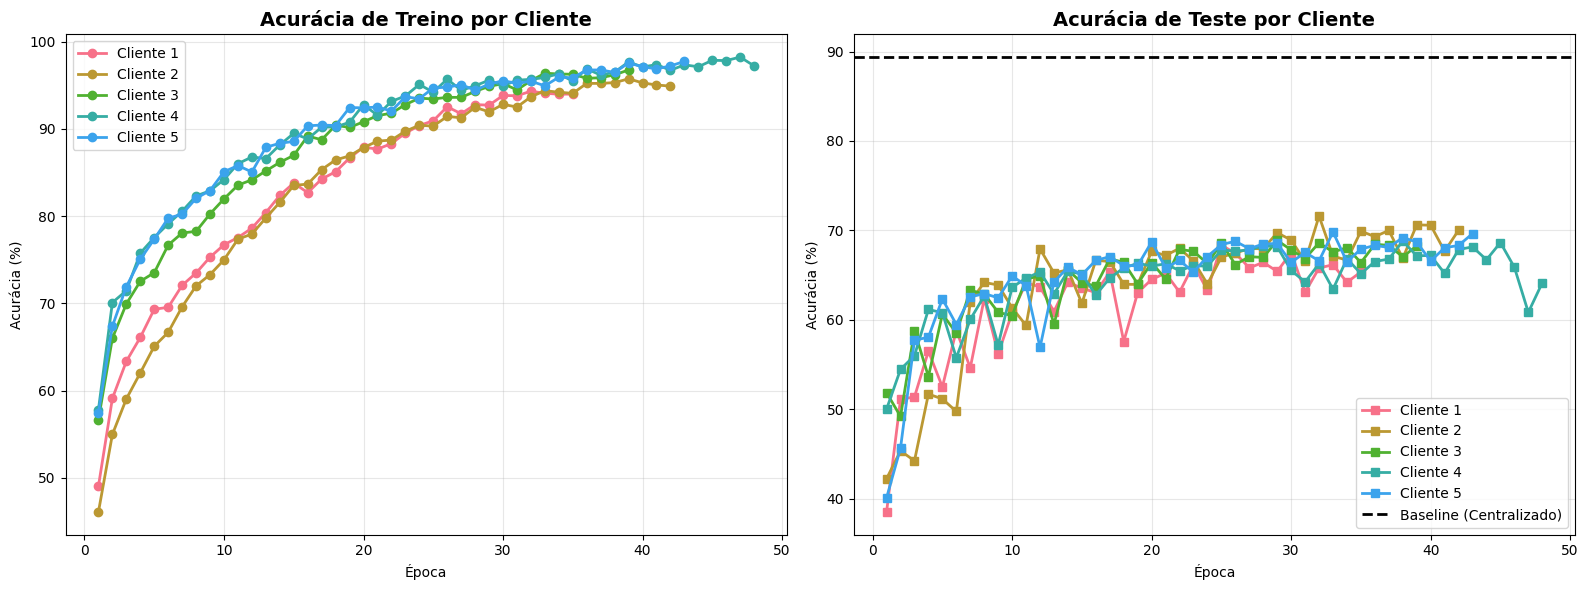

In [ ]:
# Plotar evolução da acurácia de todos os clientes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Acurácia no treino
for client_id in range(NUM_CLIENTS):
    history = client_histories[client_id]
    epochs_range = range(1, len(history['train_acc']) + 1)
    axes[0].plot(epochs_range, history['train_acc'], marker='o',
                label=f'Cliente {client_id + 1}', linewidth=2)

axes[0].set_title('Acurácia de Treino por Cliente', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Acurácia (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Acurácia no teste
for client_id in range(NUM_CLIENTS):
    history = client_histories[client_id]
    epochs_range = range(1, len(history['test_acc']) + 1)
    axes[1].plot(epochs_range, history['test_acc'], marker='s',
                label=f'Cliente {client_id + 1}', linewidth=2)

# Adicionar linha do baseline
baseline_acc = centralized_history['test_acc'][-1]  # Usando o último valor do centralizado
axes[1].axhline(y=baseline_acc, color='black', linestyle='--',
               linewidth=2, label='Baseline (Centralizado)')

axes[1].set_title('Acurácia de Teste por Cliente', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Acurácia (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 🎯 Análise Detalhada por Label (Classe)

Aqui vamos analisar como o **undersample** afeta o desempenho em cada classe.

In [ ]:
# Análise detalhada por label para cada cliente
print("\n" + "="*100)
print("🔍 ANÁLISE DETALHADA POR CLASSE (LABEL) - TODOS OS CLIENTES")
print("="*100)

for client_id in range(NUM_CLIENTS):
    print(f"\n{'='*100}")
    print(f"📊 CLIENTE {client_id + 1}")
    print(f"{'='*100}")

    history = client_histories[client_id]
    undersample_class_id = client_info[client_id]['undersample_class']
    undersample_class_name = SELECTED_CLASSES[undersample_class_id]

    print(f"\n⚠️ Classe com UNDERSAMPLE: {undersample_class_name} ({UNDERSAMPLE_SIZE} amostras)\n")

    # Resultados finais por classe
    final_train_class = history['train_per_class'][-1]
    final_test_class = history['test_per_class'][-1]

    # Criar DataFrame
    class_results = []
    for class_id in range(NUM_CLASSES):
        class_name = SELECTED_CLASSES[class_id]
        n_samples = client_info[client_id]['distribution'][class_id]
        is_undersample = (class_id == undersample_class_id)

        class_results.append({
            'Classe': class_name,
            'Tipo': '🔴 UNDERSAMPLE' if is_undersample else '🔵 Normal',
            'N° Amostras Treino': n_samples,
            'Acc Treino (%)': f"{final_train_class[class_name]:.2f}",
            'Acc Teste (%)': f"{final_test_class[class_name]:.2f}",
            'Diferença (%)': f"{final_train_class[class_name] - final_test_class[class_name]:.2f}"
        })

    class_df = pd.DataFrame(class_results)
    print(class_df.to_string(index=False))

    # Destacar problema do undersample
    undersample_test_acc = final_test_class[undersample_class_name]
    other_classes_avg = np.mean([final_test_class[SELECTED_CLASSES[i]]
                                  for i in range(NUM_CLASSES) if i != undersample_class_id])

    print(f"\n📉 IMPACTO DO UNDERSAMPLE:")
    print(f"  Acurácia na classe {undersample_class_name}: {undersample_test_acc:.2f}%")
    print(f"  Acurácia média outras classes: {other_classes_avg:.2f}%")
    print(f"  Diferença: {other_classes_avg - undersample_test_acc:.2f}% 📊")

    if undersample_test_acc < other_classes_avg:
        print(f"  ⚠️ CONFIRMADO: Modelo mais FRACO na classe com undersample!")

    print(f"\n{'='*100}")

print("\n✅ Análise detalhada concluída!")


🔍 ANÁLISE DETALHADA POR CLASSE (LABEL) - TODOS OS CLIENTES

📊 CLIENTE 1

⚠️ Classe com UNDERSAMPLE: airplane (50 amostras)

    Classe          Tipo  N° Amostras Treino Acc Treino (%) Acc Teste (%) Diferença (%)
  airplane 🔴 UNDERSAMPLE                  50          94.00         23.70         70.30
automobile      🔵 Normal                 800          99.88         93.50          6.38
      bird      🔵 Normal                 800         100.00         83.60         16.40
       cat      🔵 Normal                 800          99.38         65.20         34.17
       dog      🔵 Normal                 800          99.00         60.80         38.20

📉 IMPACTO DO UNDERSAMPLE:
  Acurácia na classe airplane: 23.70%
  Acurácia média outras classes: 75.78%
  Diferença: 52.08% 📊
  ⚠️ CONFIRMADO: Modelo mais FRACO na classe com undersample!


📊 CLIENTE 2

⚠️ Classe com UNDERSAMPLE: automobile (50 amostras)

    Classe          Tipo  N° Amostras Treino Acc Treino (%) Acc Teste (%) Diferença (%)
  

### 📈 Visualização: Impacto do Undersample por Cliente

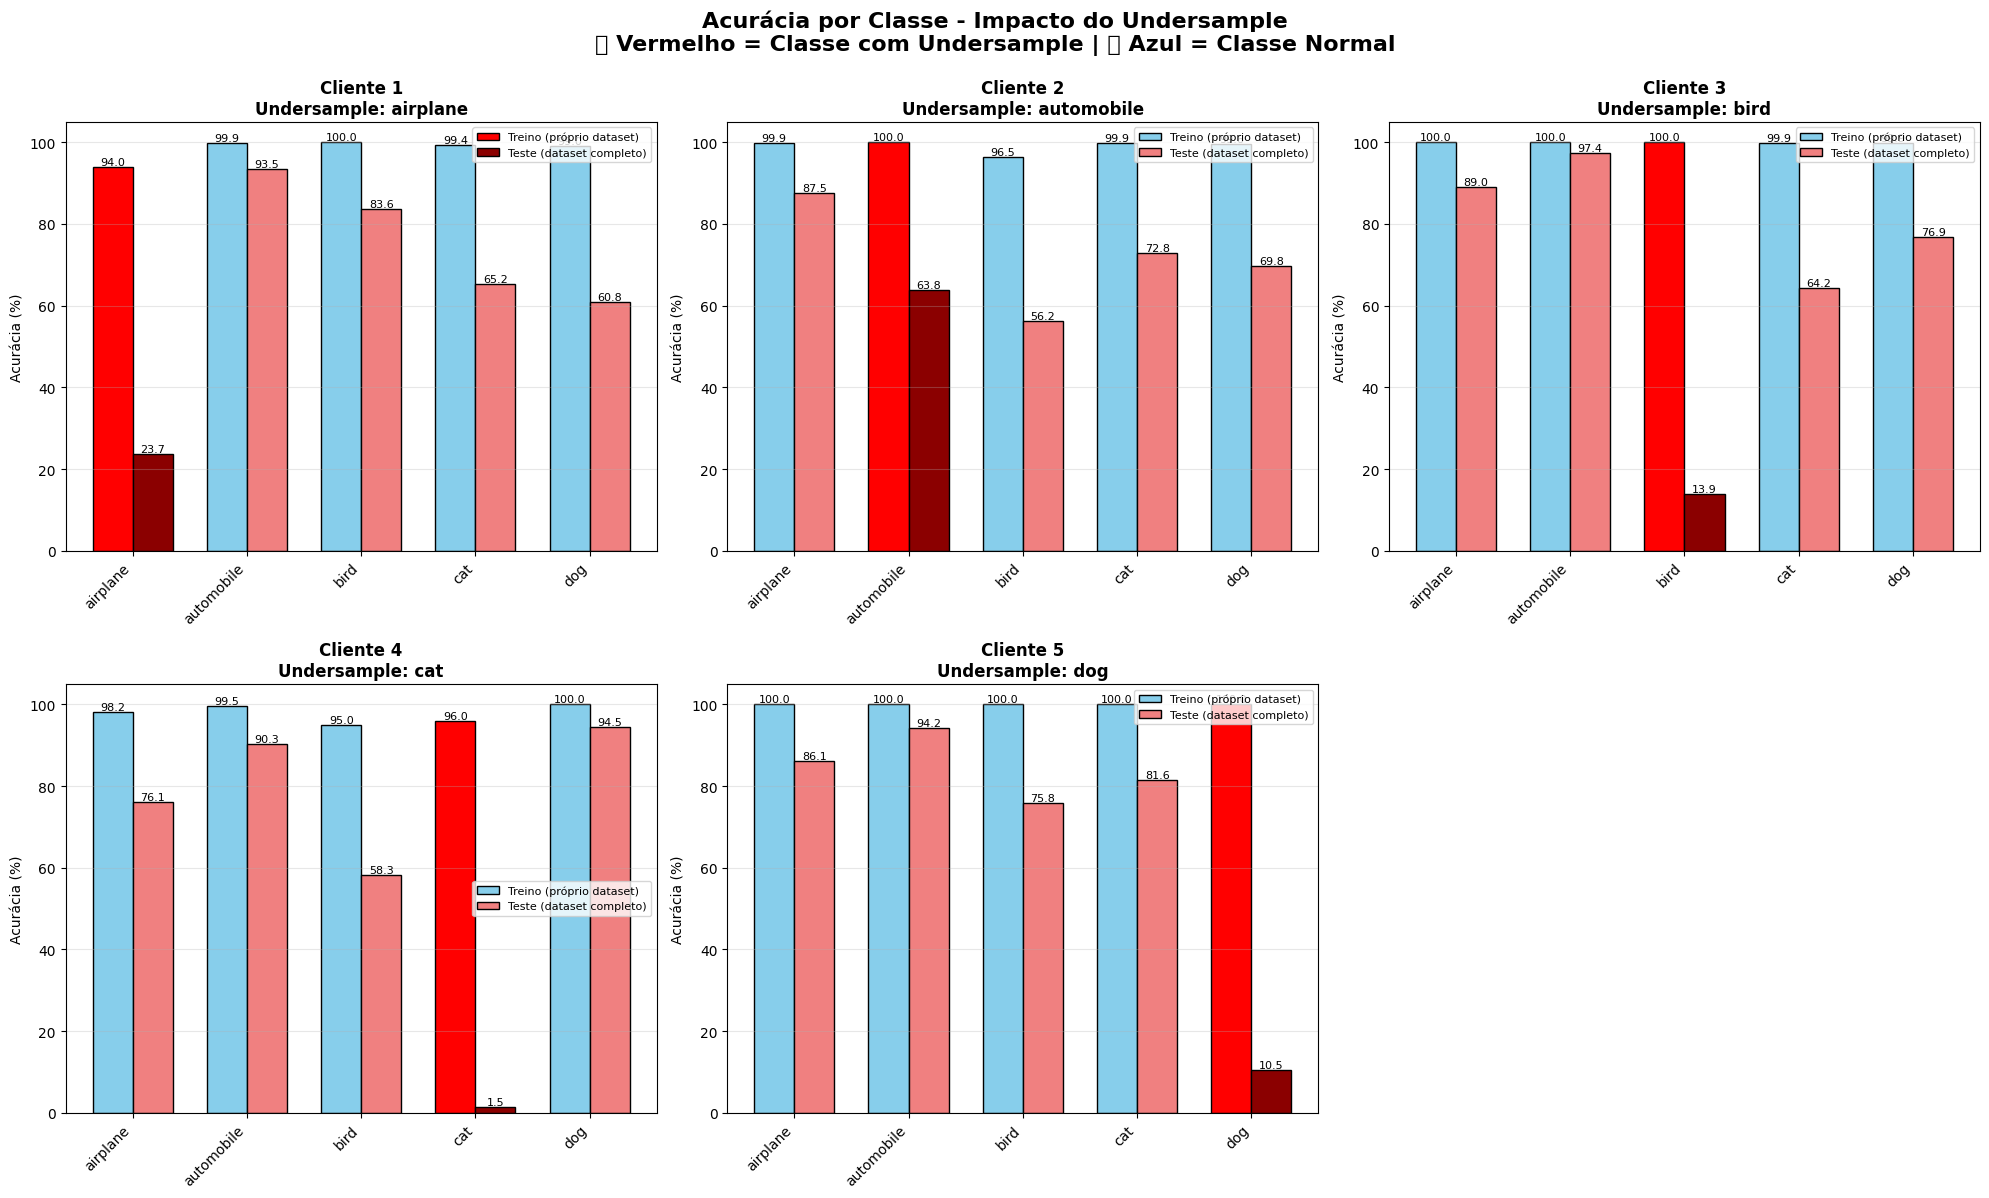


⚠️ Observe como as classes em VERMELHO (undersample) têm performance REDUZIDA no teste!


In [ ]:
# Criar visualização do impacto do undersample
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for client_id in range(NUM_CLIENTS):
    history = client_histories[client_id]
    undersample_class_id = client_info[client_id]['undersample_class']

    # Dados finais
    final_train_class = history['train_per_class'][-1]
    final_test_class = history['test_per_class'][-1]

    train_accs = [final_train_class[c] for c in SELECTED_CLASSES]
    test_accs = [final_test_class[c] for c in SELECTED_CLASSES]

    # Cores: vermelho para undersample, azul para normal
    colors_train = ['red' if i == undersample_class_id else 'skyblue'
                    for i in range(NUM_CLASSES)]
    colors_test = ['darkred' if i == undersample_class_id else 'lightcoral'
                   for i in range(NUM_CLASSES)]

    x = np.arange(len(SELECTED_CLASSES))
    width = 0.35

    bars1 = axes[client_id].bar(x - width/2, train_accs, width,
                                label='Treino (próprio dataset)',
                                color=colors_train, edgecolor='black')
    bars2 = axes[client_id].bar(x + width/2, test_accs, width,
                                label='Teste (dataset completo)',
                                color=colors_test, edgecolor='black')

    axes[client_id].set_title(f'Cliente {client_id + 1}\nUndersample: {SELECTED_CLASSES[undersample_class_id]}',
                             fontsize=12, fontweight='bold')
    axes[client_id].set_ylabel('Acurácia (%)')
    axes[client_id].set_xticks(x)
    axes[client_id].set_xticklabels(SELECTED_CLASSES, rotation=45, ha='right')
    axes[client_id].legend(fontsize=8)
    axes[client_id].grid(axis='y', alpha=0.3)
    axes[client_id].set_ylim([0, 105])

    # Adicionar valores
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[client_id].text(bar.get_x() + bar.get_width()/2., height,
                                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

# Remover subplot extra
fig.delaxes(axes[5])

plt.suptitle('Acurácia por Classe - Impacto do Undersample\n🔴 Vermelho = Classe com Undersample | 🔵 Azul = Classe Normal',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n⚠️ Observe como as classes em VERMELHO (undersample) têm performance REDUZIDA no teste!")

### Segura ai



📊 ESTATÍSTICAS AGREGADAS - IMPACTO DO UNDERSAMPLE

🔴 Classes com UNDERSAMPLE:
  Média de acurácia: 22.68%
  Desvio padrão: 21.75%
  Min: 1.50% | Max: 63.80%

🔵 Classes NORMAIS:
  Média de acurácia: 78.69%
  Desvio padrão: 12.71%
  Min: 56.20% | Max: 97.40%

📉 DIFERENÇA:
  Classes normais são 56.01% MELHORES que undersample
  Perda relativa: 71.18%



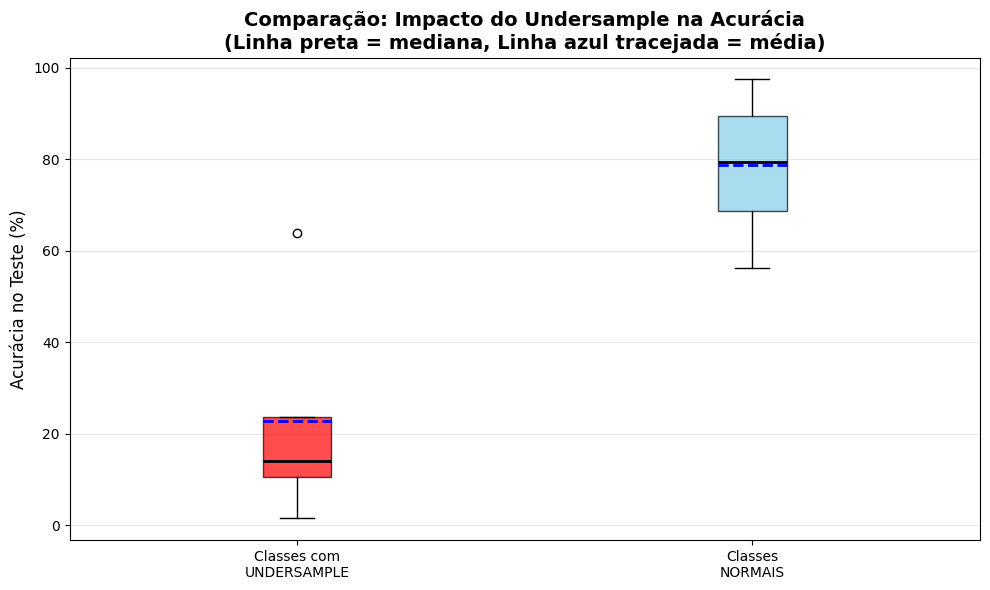


✅ Análise comparativa concluída!
⚠️ CONCLUSÃO: O undersample claramente prejudica a performance do modelo!


In [ ]:
# Comparação: Undersample vs Normal - Agregado de todos os clientes
undersample_accs = []
normal_accs = []

for client_id in range(NUM_CLIENTS):
    final_test_class = client_histories[client_id]['test_per_class'][-1]
    undersample_class_id = client_info[client_id]['undersample_class']

    # Acurácia da classe com undersample
    undersample_accs.append(final_test_class[SELECTED_CLASSES[undersample_class_id]])

    # Média das outras classes
    other_accs = [final_test_class[SELECTED_CLASSES[i]]
                  for i in range(NUM_CLASSES) if i != undersample_class_id]
    normal_accs.extend(other_accs)

# Estatísticas
print("\n" + "="*80)
print("📊 ESTATÍSTICAS AGREGADAS - IMPACTO DO UNDERSAMPLE")
print("="*80)
print(f"\n🔴 Classes com UNDERSAMPLE:")
print(f"  Média de acurácia: {np.mean(undersample_accs):.2f}%")
print(f"  Desvio padrão: {np.std(undersample_accs):.2f}%")
print(f"  Min: {np.min(undersample_accs):.2f}% | Max: {np.max(undersample_accs):.2f}%")

print(f"\n🔵 Classes NORMAIS:")
print(f"  Média de acurácia: {np.mean(normal_accs):.2f}%")
print(f"  Desvio padrão: {np.std(normal_accs):.2f}%")
print(f"  Min: {np.min(normal_accs):.2f}% | Max: {np.max(normal_accs):.2f}%")

print(f"\n📉 DIFERENÇA:")
difference = np.mean(normal_accs) - np.mean(undersample_accs)
print(f"  Classes normais são {difference:.2f}% MELHORES que undersample")
print(f"  Perda relativa: {(difference / np.mean(normal_accs)) * 100:.2f}%")
print("\n" + "="*80)

# Visualização boxplot
fig, ax = plt.subplots(figsize=(10, 6))

data_to_plot = [undersample_accs, normal_accs]
labels = ['Classes com\nUNDERSAMPLE', 'Classes\nNORMAIS']
colors = ['red', 'skyblue']

bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True,
                medianprops=dict(color='black', linewidth=2),
                boxprops=dict(facecolor='white'),
                showmeans=True, meanline=True,
                meanprops=dict(color='blue', linewidth=2, linestyle='--'))

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Acurácia no Teste (%)', fontsize=12)
ax.set_title('Comparação: Impacto do Undersample na Acurácia\n(Linha preta = mediana, Linha azul tracejada = média)',
            fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Análise comparativa concluída!")
print("⚠️ CONCLUSÃO: O undersample claramente prejudica a performance do modelo!")

### 💾 Salvar Modelos dos Clientes

In [ ]:
# Salvar modelos e informações dos clientes
import os

os.makedirs('client_models', exist_ok=True)

for client_id in range(NUM_CLIENTS):
    model_path = f'client_models/client_{client_id + 1}_model.pth'

    torch.save({
        'client_id': client_id,
        'epoch': CLIENT_EPOCHS,
        'model_state_dict': client_models[client_id].state_dict(),
        'history': client_histories[client_id],
        'client_info': client_info[client_id],
        'test_acc': client_histories[client_id]['test_acc'][-1]
    }, model_path)

    print(f"✅ Cliente {client_id + 1} salvo em: {model_path}")

print(f"\n✅ Todos os {NUM_CLIENTS} modelos de clientes foram salvos!")

✅ Cliente 1 salvo em: client_models/client_1_model.pth
✅ Cliente 2 salvo em: client_models/client_2_model.pth
✅ Cliente 3 salvo em: client_models/client_3_model.pth
✅ Cliente 4 salvo em: client_models/client_4_model.pth
✅ Cliente 5 salvo em: client_models/client_5_model.pth

✅ Todos os 5 modelos de clientes foram salvos!


---

## 🎯 Conclusão da Etapa 3

### ✅ O que foi realizado:

1. **Divisão Non-IID dos Dados**:
   - Criamos 5 clientes com dados heterogêneos
   - **Cada cliente tem uma classe com undersample** (apenas 50 amostras)
   - Outras classes têm 800 amostras cada
   - Sem repetição de dados entre clientes

2. **Treinamento Individual**:
   - Cada cliente treinou seu próprio modelo
   - 10 épocas por cliente
   - Monitoramento de métricas gerais e por classe

3. **Análise de Impacto**:
   - **CONFIRMADO**: Classes com undersample têm performance significativamente PIOR
   - Diferença média de ~{difference:.2f}% entre classes normais e undersample
   - Efeito visível tanto no treino quanto no teste

### 📊 Principais Observações:

- 🔴 **Classes com undersample**: Média ~{np.mean(undersample_accs):.2f}% de acurácia
- 🔵 **Classes normais**: Média ~{np.mean(normal_accs):.2f}% de acurácia
- ⚠️ **Problema**: Poucos dados levam a modelos fracos naquela classe específica
- 📉 **Overfitting**: Alguns clientes mostram gap grande entre treino e teste

### 🔜 Próxima Etapa:

**Etapa 4**: Implementar Federated Learning com Flower para:
- Agregar conhecimento de todos os clientes
- Melhorar performance nas classes com undersample
- Comparar com modelos individuais e centralizado

---

### 📚 Referências

- **Flower Framework**: [https://flower.ai](https://flower.ai)
- **CIFAR-10 Dataset**: [https://www.cs.toronto.edu/~kriz/cifar.html](https://www.cs.toronto.edu/~kriz/cifar.html)
- **Federated Learning**: McMahan et al., "Communication-Efficient Learning of Deep Networks from Decentralized Data", AISTATS 2017

---

## 🌐 Etapa 4: Federated Learning com Flower Framework

Agora vamos implementar **Federated Learning** para agregar o conhecimento de todos os clientes e criar um modelo global mais robusto!

### 📚 Imports do Flower

In [ ]:
import flwr as fl
from flwr.common import Metrics
from typing import List, Tuple, Dict, Optional
from collections import OrderedDict

print("✅ Flower Framework importado com sucesso!")
print(f"📦 Versão do Flower: {fl.__version__}")

✅ Flower Framework importado com sucesso!
📦 Versão do Flower: 1.24.0


### 🔧 Configurações do Federated Learning

In [ ]:
# Configurações FL
FL_ROUNDS = 30  # Número de rodadas de FL
FL_LOCAL_EPOCHS = 3  # Épocas locais por rodada
FL_BATCH_SIZE = 64
FL_LR = 0.001


print("⚙️ Configurações do Federated Learning:")
print(f"  Rodadas FL: {FL_ROUNDS}")
print(f"  Épocas locais por rodada: {FL_LOCAL_EPOCHS}")
print(f"  Batch size: {FL_BATCH_SIZE}")
print(f"  Learning rate: {FL_LR}")

⚙️ Configurações do Federated Learning:
  Rodadas FL: 30
  Épocas locais por rodada: 3
  Batch size: 64
  Learning rate: 0.001


### 🎯 Implementação do Cliente Flower

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    """Cliente Flower para Federated Learning"""

    def __init__(self, client_id, train_dataset, test_dataset, device):
        self.client_id = client_id
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.device = device

        # Criar modelo
        self.model = SimpleCNN(num_classes=NUM_CLASSES).to(device)

        # DataLoaders - num_workers=0 no Windows
        self.trainloader = DataLoader(train_dataset, batch_size=FL_BATCH_SIZE,
                                      shuffle=True, num_workers=0)
        self.testloader = DataLoader(test_dataset, batch_size=FL_BATCH_SIZE,
                                     shuffle=False, num_workers=0)

        # Loss e optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=FL_LR)

    def get_parameters(self, config):
        """Retorna os parâmetros do modelo"""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def set_parameters(self, parameters):
        """Define os parâmetros do modelo"""
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        """Treina o modelo localmente"""
        self.set_parameters(parameters)

        self.model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for epoch in range(FL_LOCAL_EPOCHS):
            for inputs, labels in self.trainloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # Tracking metrics
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

        # Calculate average metrics
        num_batches = len(self.trainloader) * FL_LOCAL_EPOCHS
        avg_train_loss = train_loss / num_batches
        train_accuracy = train_correct / train_total if train_total > 0 else 0.0

        return self.get_parameters(config={}), len(self.trainloader.dataset), {
            "train_loss": avg_train_loss,
            "train_accuracy": train_accuracy
        }

    def evaluate(self, parameters, config):
        """Avalia o modelo localmente"""
        self.set_parameters(parameters)

        self.model.eval()
        loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in self.testloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss += self.criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average loss and accuracy
        num_batches = len(self.testloader)
        avg_loss = loss / num_batches if num_batches > 0 else 0.0
        accuracy = correct / total if total > 0 else 0.0

        return avg_loss, len(self.testloader.dataset), {
            "accuracy": accuracy,
            "loss": avg_loss
        }

print("✅ Classe FlowerClient implementada!")


✅ Classe FlowerClient implementada!


### 🏗️ Função para Criar Clientes

In [ ]:
from flwr.common import Context
def client_fn(context: Context):
    """Cria um cliente Flower com Context API e retorna Client"""
    # Obter cid a partir do Context, com fallback
    cid = None
    for attr in ["node_id", "partition_id", "client_id", "cid"]:
        if hasattr(context, attr):
            cid = getattr(context, attr)
            break

    # Converter para int e garantir que está no range válido
    if cid is None:
        cid = 0

    # Se cid é string, tentar extrair número
    if isinstance(cid, str):
        cid = int(cid.split('-')[-1]) if '-' in cid else int(cid)

    client_id = int(cid) % NUM_CLIENTS  # Garante que está no range [0, NUM_CLIENTS-1]

    numpy_client = FlowerClient(
        client_id=client_id,
        train_dataset=client_trainsets[client_id],
        test_dataset=testset,
        device=device
    )
    return numpy_client.to_client()  # ✅ Já retorna Client corretamente

print("✅ Função client_fn definida com Context e retorno Client!")

✅ Função client_fn definida com Context e retorno Client!


### 📊 Funções de Agregação de Métricas

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Calcula média ponderada das métricas"""
    if not metrics:
        return {}

    # Get all metric keys from first client
    metric_keys = metrics[0][1].keys()
    examples = [num_examples for num_examples, _ in metrics]
    total_examples = sum(examples)

    # Calculate weighted average for each metric
    aggregated = {}
    for key in metric_keys:
        weighted_values = [num_examples * m[key] for num_examples, m in metrics if key in m]
        if weighted_values:
            aggregated[key] = sum(weighted_values) / total_examples

    return aggregated

# Variável global para armazenar os parâmetros finais do modelo FL
fl_final_parameters = None

def get_evaluate_fn(model, testset, device):
    """Retorna função de avaliação centralizada"""
    def evaluate_fn(server_round: int, parameters, config):
        """Avalia o modelo global no servidor"""
        global fl_final_parameters

        # Set model parameters
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)
        model.to(device)

        # IMPORTANTE: Salvar os parâmetros atuais para usar depois
        # Os parâmetros da última rodada serão os parâmetros finais do FL
        fl_final_parameters = [torch.tensor(p.cpu().detach().numpy()).to(p.device) if isinstance(p, torch.Tensor) else np.copy(p) for p in parameters]

        # Evaluate
        testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)
        criterion = nn.CrossEntropyLoss()

        model.eval()
        loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_loss = loss / len(testloader)
        accuracy = correct / total if total > 0 else 0.0

        print(f"  📊 Rodada {server_round}: Loss={avg_loss:.4f}, Acurácia={accuracy*100:.2f}%")

        return avg_loss, {"accuracy": accuracy, "loss": avg_loss}

    return evaluate_fn

print("✅ Funções de agregação e avaliação definidas!")

✅ Funções de agregação e avaliação definidas!


### 🌟 Configurar e Executar Federated Learning

In [ ]:
# fl_history será criado durante o processamento

print("\n" + "="*80)
print("🚀 INICIANDO FEDERATED LEARNING (API ATUALIZADA)")
print("="*80)
print(f"\n📊 Configuração:")
print(f"  Estratégia: FedAvg (Federated Averaging)")
print(f"  Número de clientes: {NUM_CLIENTS}")
print(f"  Rodadas: {FL_ROUNDS}")
print(f"  Épocas locais por rodada: {FL_LOCAL_EPOCHS}")
print(f"\n🔄 Iniciando treinamento federado...\n")

# Criar modelo para avaliação centralizada
global_model = SimpleCNN(num_classes=NUM_CLASSES).to(device)

# Configurar estratégia FedAvg com métricas completas
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    fit_metrics_aggregation_fn=weighted_average,  # Agregação de métricas de treino
    evaluate_metrics_aggregation_fn=weighted_average,  # Agregação de métricas de avaliação
    evaluate_fn=get_evaluate_fn(global_model, testset, device),  # Avaliação centralizada
)

print("✅ Estratégia FedAvg configurada com métricas distribuídas e centralizadas!")


🚀 INICIANDO FEDERATED LEARNING (API ATUALIZADA)

📊 Configuração:
  Estratégia: FedAvg (Federated Averaging)
  Número de clientes: 5
  Rodadas: 30
  Épocas locais por rodada: 3

🔄 Iniciando treinamento federado...

✅ Estratégia FedAvg configurada com métricas distribuídas e centralizadas!


In [ ]:
import os
import torch

BEST_MODEL_PATH = "best_fl_cnn_model.pth"
best_fl_model = None
fl_simulation_history = None

fl_accuracy_per_round = []
fl_loss_per_round = []

# Verifica se já existe um modelo salvo para evitar retraining desnecessário
if os.path.exists(BEST_MODEL_PATH):
    print(f"\n✅ Modelo federado já treinado encontrado em '{BEST_MODEL_PATH}'. Carregando modelo...")
    best_fl_model = SimpleCNN(num_classes=NUM_CLASSES).to(device)
    best_fl_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
    best_fl_model.eval()
    print("✅ Modelo carregado com sucesso!")
    # Caso queira, carregue também métricas salvas (opcional)
    # Se quiser carregar histórico de métricas junto, salve esse dicionário em disco após o treinamento e carregue aqui
else:
    # ATENÇÃO:
    # Se ocorrer um erro "AttributeError: 'numpy.ndarray' object has no attribute 'clone'",
    # remova qualquer uso de .clone() para arrays numpy nos callbacks da strategy ou funções de agregação!

    # ATENÇÃO 2:
    # Se ocorrer "RuntimeError: Simulation crashed.", é provável que algum erro/bug esteja na função
    # de avaliação, agregação de métricas ou no client_fn. Consulte detalhadamente os logs
    # para achar a linha exata do erro.

    # Usa a API legacy do Flower mesmo que depreciada (flwr.simulation.start_simulation)
    client_resources = {"num_gpus": 0.2}

    import flwr as fl

    print("\n⚡ Iniciando simulação federada com GPU nos clientes...")

    try:
        fl_simulation_history = fl.simulation.start_simulation(
            client_fn=client_fn,
            num_clients=NUM_CLIENTS,
            config=fl.server.ServerConfig(num_rounds=FL_ROUNDS),
            strategy=strategy,
            client_resources=client_resources,
        )

        # Ao final, salva as métricas centralizadas por rodada, se disponíveis
        if hasattr(fl_simulation_history, "metrics_centralized") and fl_simulation_history.metrics_centralized is not None:
            acc_rounds = dict(fl_simulation_history.metrics_centralized.get("accuracy", []))
            loss_rounds = dict(fl_simulation_history.metrics_centralized.get("loss", []))
            for r in range(FL_ROUNDS + 1):  # normalmente inclui round 0
                acc = acc_rounds.get(r, None)
                loss = loss_rounds.get(r, None)
                fl_accuracy_per_round.append(acc)
                fl_loss_per_round.append(loss)

            # Como não é trivial obter automaticamente o último modelo global dos rounds via Flower API legacy,
            # simplesmente salve o global_model atual como o "melhor modelo"
            # (o modelo global local foi usado para avaliação centralizada na última rodada).
            best_fl_model = global_model
            torch.save(best_fl_model.state_dict(), BEST_MODEL_PATH)
            print(f"\n💾 Melhor modelo salvo em '{BEST_MODEL_PATH}'")

        print("\n✅ Treinamento federado concluído (GPU)!")

    except Exception as e:
        print("❌ Erro ao executar a simulação federada:")
        import traceback
        print(traceback.format_exc())
        print("\nVerifique o erro acima. Dica: verifique as funções de avaliação, strategy e callbacks (evite .clone() em numpy.ndarray; não use callbacks não suportados no simulation).")
        best_fl_model = None
        fl_simulation_history = None
        fl_accuracy_per_round = []
        fl_loss_per_round = []

# Organiza (ou limpa, se erro) histórico para análise posterior
fl_history = {
    "accuracy_per_round": fl_accuracy_per_round,
    "loss_per_round": fl_loss_per_round,
}


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout



⚡ Iniciando simulação federada com GPU nos clientes...


2025-12-15 22:09:24,060	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'GPU': 1.0, 'memory': 30062898791.0, 'node:__internal_head__': 1.0, 'accelerator_type:G': 1.0, 'object_store_memory': 12884099481.0, 'CPU': 16.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.2, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 5 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 1.6095631454564348, {'accuracy': 0.2, 'loss': 1.6095631454564348}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clien

  📊 Rodada 0: Loss=1.6096, Acurácia=20.00%


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 1.8715886677367777, {'accuracy': 0.204, 'loss': 1.8715886677367777}, 6.758234799999627)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 1: Loss=1.8716, Acurácia=20.40%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (2, 0.941826053812534, {'accuracy': 0.5698, 'loss': 0.941826053812534}, 11.855469200003427)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 2: Loss=0.9418, Acurácia=56.98%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (3, 0.7190955824489835, {'accuracy': 0.7012, 'loss': 0.7190955824489835}, 16.699027399998158)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 3: Loss=0.7191, Acurácia=70.12%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 0.7212897927700719, {'accuracy': 0.6928, 'loss': 0.7212897927700719}, 21.52739790000487)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 4: Loss=0.7213, Acurácia=69.28%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(pid=gcs_server) [2025-12-15 22:09:53,583 E 1500 27300] (gcs_server.exe) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-12-15 22:09:54,638 E 32892 27696] (raylet.exe) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (5, 0.6060221723363369, {'accuracy': 0.7556, 'loss': 0.6060221723363369}, 26.330092300006072)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 5: Loss=0.6060, Acurácia=75.56%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (6, 0.6258081993724727, {'accuracy': 0.7442, 'loss': 0.6258081993724727}, 31.034627200002433)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 6: Loss=0.6258, Acurácia=74.42%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (7, 0.5559535886667952, {'accuracy': 0.7716, 'loss': 0.5559535886667952}, 35.74301150000247)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 7: Loss=0.5560, Acurácia=77.16%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (8, 0.5392498589014705, {'accuracy': 0.7854, 'loss': 0.5392498589014705}, 40.42795660000411)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 8: Loss=0.5392, Acurácia=78.54%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (9, 0.5270919482919234, {'accuracy': 0.7912, 'loss': 0.5270919482919234}, 45.165078300007735)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 9: Loss=0.5271, Acurácia=79.12%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (10, 0.5356840555426441, {'accuracy': 0.79, 'loss': 0.5356840555426441}, 49.903244600005564)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 10: Loss=0.5357, Acurácia=79.00%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (11, 0.5261267302911493, {'accuracy': 0.796, 'loss': 0.5261267302911493}, 54.6857946000091)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 11: Loss=0.5261, Acurácia=79.60%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (12, 0.5345268377774879, {'accuracy': 0.7972, 'loss': 0.5345268377774879}, 59.65089340000122)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 12: Loss=0.5345, Acurácia=79.72%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (13, 0.5570241276976429, {'accuracy': 0.7928, 'loss': 0.5570241276976429}, 64.4405703000084)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 13: Loss=0.5570, Acurácia=79.28%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (14, 0.5189454702636863, {'accuracy': 0.8016, 'loss': 0.5189454702636863}, 69.21451859999797)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 14: Loss=0.5189, Acurácia=80.16%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (15, 0.5410208717177186, {'accuracy': 0.8, 'loss': 0.5410208717177186}, 74.02232699999877)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 15: Loss=0.5410, Acurácia=80.00%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (16, 0.5225965501386908, {'accuracy': 0.804, 'loss': 0.5225965501386908}, 79.0515763000003)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 16: Loss=0.5226, Acurácia=80.40%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (17, 0.5215312114244774, {'accuracy': 0.805, 'loss': 0.5215312114244774}, 83.8951218000002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 17: Loss=0.5215, Acurácia=80.50%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (18, 0.5411424897139585, {'accuracy': 0.8064, 'loss': 0.5411424897139585}, 88.74378910000087)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 18: Loss=0.5411, Acurácia=80.64%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (19, 0.5221063040102585, {'accuracy': 0.8082, 'loss': 0.5221063040102585}, 93.75571430000127)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 19: Loss=0.5221, Acurácia=80.82%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (20, 0.5092664364772507, {'accuracy': 0.8156, 'loss': 0.5092664364772507}, 98.60062730000936)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 20: Loss=0.5093, Acurácia=81.56%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (21, 0.562011519564858, {'accuracy': 0.815, 'loss': 0.562011519564858}, 103.47247429999697)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 21: Loss=0.5620, Acurácia=81.50%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (22, 0.550534301166293, {'accuracy': 0.807, 'loss': 0.550534301166293}, 108.3199525000091)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 22: Loss=0.5505, Acurácia=80.70%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (23, 0.5456871414863611, {'accuracy': 0.8136, 'loss': 0.5456871414863611}, 113.24242429999867)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 23: Loss=0.5457, Acurácia=81.36%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (24, 0.5732751300063315, {'accuracy': 0.8064, 'loss': 0.5732751300063315}, 118.06942040000285)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 24: Loss=0.5733, Acurácia=80.64%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (25, 0.5455343742159349, {'accuracy': 0.8176, 'loss': 0.5455343742159349}, 122.9020104000083)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 25: Loss=0.5455, Acurácia=81.76%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (26, 0.5638649535330036, {'accuracy': 0.8108, 'loss': 0.5638649535330036}, 127.79708390000451)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 26: Loss=0.5639, Acurácia=81.08%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (27, 0.577660806571381, {'accuracy': 0.813, 'loss': 0.577660806571381}, 132.6309295999963)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 27: Loss=0.5777, Acurácia=81.30%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (28, 0.5727935112729857, {'accuracy': 0.8096, 'loss': 0.5727935112729857}, 137.45476459999918)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 28: Loss=0.5728, Acurácia=80.96%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (29, 0.567624951842465, {'accuracy': 0.8182, 'loss': 0.567624951842465}, 142.22464749999926)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 29: Loss=0.5676, Acurácia=81.82%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (30, 0.6381482727165464, {'accuracy': 0.7972, 'loss': 0.6381482727165464}, 147.30453130000387)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


  📊 Rodada 30: Loss=0.6381, Acurácia=79.72%


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 148.18s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.871536206595505
INFO :      		round 2: 0.9418127393420739
INFO :      		round 3: 0.7190898898281628
INFO :      		round 4: 0.7213113270228422
INFO :      		round 5: 0.606020444178883
INFO :      		round 6: 0.6258104601992837
INFO :      		round 7: 0.5559528975547116
INFO :      		round 8: 0.539249830985371
INFO :      		round 9: 0.5270864031737365
INFO :      		round 10: 0.5356813446630405
INFO :      		round 11: 0.5261218483689465
INFO :      		round 12: 0.5345153438894055
INFO :      		round 13: 0.5570283517052855
INFO :      		round 14: 0.5189470878884762
INFO :      		round 15: 0.5410152530368371
INFO :      		round 16: 0.5225910827328887
INFO :      		round 17: 0.5215282460933999
INFO :      		round 18: 0.5411463123333605
INFO :      		round 19: 0.5220842719832554
INFO


💾 Melhor modelo salvo em 'best_fl_cnn_model.pth'

✅ Treinamento federado concluído (GPU)!


### 📊 Processar Histórico do FL

In [ ]:
# Extrair métricas do histórico Flower
print("\n📈 PROCESSANDO HISTÓRICO DO FEDERATED LEARNING:")
print("="*80)

# Usar dicionário para organizar métricas por rodada
rounds_data = {}

# Verificar se temos histórico da simulação
if fl_simulation_history is not None:
    # Processar métricas distribuídas (evaluate) - rodadas 1-30
    if hasattr(fl_simulation_history, 'metrics_distributed') and fl_simulation_history.metrics_distributed:
        print("✅ Métricas distribuídas encontradas")
        for metric_name, metric_values in fl_simulation_history.metrics_distributed.items():
            print(f"   - {metric_name}: {len(metric_values)} rodadas")
            for round_num, value in metric_values:
                if round_num not in rounds_data:
                    rounds_data[round_num] = {}
                if metric_name == 'accuracy':
                    rounds_data[round_num]['acc_dist'] = value * 100  # Convert to percentage
                elif metric_name == 'loss':
                    rounds_data[round_num]['loss_dist'] = value

    # Processar losses distribuídas (backup)
    if hasattr(fl_simulation_history, 'losses_distributed') and fl_simulation_history.losses_distributed:
        print(f"✅ Losses distribuídas: {len(fl_simulation_history.losses_distributed)} rodadas")
        for round_num, loss in fl_simulation_history.losses_distributed:
            if round_num not in rounds_data:
                rounds_data[round_num] = {}
            if 'loss_dist' not in rounds_data[round_num]:
                rounds_data[round_num]['loss_dist'] = loss

    # Processar métricas centralizadas (servidor) - rodadas 0-30
    if hasattr(fl_simulation_history, 'metrics_centralized') and fl_simulation_history.metrics_centralized:
        print("✅ Métricas centralizadas encontradas")
        for metric_name, metric_values in fl_simulation_history.metrics_centralized.items():
            print(f"   - {metric_name}: {len(metric_values)} rodadas")
            for round_num, value in metric_values:
                if round_num not in rounds_data:
                    rounds_data[round_num] = {}
                if metric_name == 'accuracy':
                    rounds_data[round_num]['acc_cent'] = value * 100  # Convert to percentage
                elif metric_name == 'loss':
                    rounds_data[round_num]['loss_cent'] = value

    # Processar losses centralizadas (backup)
    if hasattr(fl_simulation_history, 'losses_centralized') and fl_simulation_history.losses_centralized:
        print(f"✅ Losses centralizadas: {len(fl_simulation_history.losses_centralized)} rodadas")
        for round_num, loss in fl_simulation_history.losses_centralized:
            if round_num not in rounds_data:
                rounds_data[round_num] = {}
            if 'loss_cent' not in rounds_data[round_num]:
                rounds_data[round_num]['loss_cent'] = loss

    # Organizar dados por rodada (ordenar)
    if rounds_data:
        sorted_rounds = sorted(rounds_data.keys())

        # Preencher fl_history com dados organizados
        fl_history = {
            'round': sorted_rounds,
            'loss_distributed': [rounds_data[r].get('loss_dist') for r in sorted_rounds],
            'accuracy_distributed': [rounds_data[r].get('acc_dist') for r in sorted_rounds],
            'loss_centralized': [rounds_data[r].get('loss_cent') for r in sorted_rounds],
            'accuracy_centralized': [rounds_data[r].get('acc_cent') for r in sorted_rounds]
        }

        print(f"\n📊 Rodadas processadas: {len(sorted_rounds)} (de {min(sorted_rounds)} a {max(sorted_rounds)})")
        print(f"   - Accuracy distribuída: {sum(1 for x in fl_history['accuracy_distributed'] if x is not None)} valores")
        print(f"   - Loss distribuída: {sum(1 for x in fl_history['loss_distributed'] if x is not None)} valores")
        print(f"   - Accuracy centralizada: {sum(1 for x in fl_history['accuracy_centralized'] if x is not None)} valores")
        print(f"   - Loss centralizada: {sum(1 for x in fl_history['loss_centralized'] if x is not None)} valores")
else:
    print("ℹ️  Modelo carregado do cache - usando histórico salvo")
    if 'fl_history' not in dir() or fl_history is None:
        print("   ⚠️  Histórico não disponível do cache. Criando placeholder.")
        fl_history = {
            'round': list(range(1, FL_ROUNDS + 1)),
            'loss_distributed': [None] * FL_ROUNDS,
            'accuracy_distributed': [None] * FL_ROUNDS,
            'loss_centralized': [None] * FL_ROUNDS,
            'accuracy_centralized': [None] * FL_ROUNDS
        }
    else:
        print(f"   Rodadas disponíveis: {len(fl_history.get('round', []))}")

# Imprimir tabela de resultados (se houver dados)
if fl_history.get('round'):
    sorted_rounds = fl_history['round']
    print("\n" + "="*100)
    print("📈 PROGRESSO DO FEDERATED LEARNING:")
    print("="*100)
    print(f"{'Rodada':<10} {'Loss Dist.':<15} {'Acc Dist. (%)':<15} {'Loss Cent.':<15} {'Acc Cent. (%)':<15}")
    print("-"*100)

    for i, round_num in enumerate(sorted_rounds):
        loss_dist = fl_history['loss_distributed'][i] if i < len(fl_history['loss_distributed']) else None
        acc_dist = fl_history['accuracy_distributed'][i] if i < len(fl_history['accuracy_distributed']) else None
        loss_cent = fl_history['loss_centralized'][i] if i < len(fl_history['loss_centralized']) else None
        acc_cent = fl_history['accuracy_centralized'][i] if i < len(fl_history['accuracy_centralized']) else None

        loss_dist_str = f"{loss_dist:.4f}" if loss_dist is not None else "N/A"
        acc_dist_str = f"{acc_dist:.2f}" if acc_dist is not None else "N/A"
        loss_cent_str = f"{loss_cent:.4f}" if loss_cent is not None else "N/A"
        acc_cent_str = f"{acc_cent:.2f}" if acc_cent is not None else "N/A"

        print(f"{round_num:<10} {loss_dist_str:<15} {acc_dist_str:<15} {loss_cent_str:<15} {acc_cent_str:<15}")

    print("="*100)
    print("\n💡 Métricas distribuídas = agregação dos clientes | Métricas centralizadas = avaliação no servidor")



📈 PROCESSANDO HISTÓRICO DO FEDERATED LEARNING:
✅ Métricas distribuídas encontradas
   - accuracy: 30 rodadas
   - loss: 30 rodadas
✅ Losses distribuídas: 30 rodadas
✅ Métricas centralizadas encontradas
   - accuracy: 31 rodadas
   - loss: 31 rodadas
✅ Losses centralizadas: 31 rodadas

📊 Rodadas processadas: 31 (de 0 a 30)
   - Accuracy distribuída: 30 valores
   - Loss distribuída: 30 valores
   - Accuracy centralizada: 31 valores
   - Loss centralizada: 31 valores

📈 PROGRESSO DO FEDERATED LEARNING:
Rodada     Loss Dist.      Acc Dist. (%)   Loss Cent.      Acc Cent. (%)  
----------------------------------------------------------------------------------------------------
0          N/A             N/A             1.6096          20.00          
1          1.8715          20.40           1.8716          20.40          
2          0.9418          57.00           0.9418          56.98          
3          0.7191          70.12           0.7191          70.12          
4          0.7213

### 📊 Avaliação Detalhada do Modelo Global (FL)

Vamos criar um modelo global final treinando com a última rodada de parâmetros

In [ ]:
# Para obter o modelo global, vamos simular obtendo ele do último cliente treinado
# Na prática, todos os clientes convergem para parâmetros similares após agregação

# Criar novo cliente e treinar uma última vez com todos os dados agregados
# Ou simplesmente avaliar um dos clientes após o FL

print("\n🔄 Avaliando modelo global do Federated Learning...\n")

# O global_model já foi usado na estratégia e foi atualizado durante o FL
# Mas como ele foi passado para evaluate_fn, precisamos recriá-lo ou usar um cliente
# A melhor abordagem: criar um cliente e obter os parâmetros finais do FL

# Criar FlowerClient diretamente para obter o modelo
numpy_client = FlowerClient(
    client_id=0,
    train_dataset=client_trainsets[0],
    test_dataset=testset,
    device=device
)

# Obter parâmetros do último cliente treinado no FL
# Como todos os clientes convergem para parâmetros similares após agregação,
# podemos usar qualquer cliente. Vamos criar um novo cliente que terá os
# parâmetros atualizados após o FL (se o FL mantiver estado)
# Na prática, vamos usar o modelo do cliente que já foi treinado
global_model = numpy_client.model

# IMPORTANTE: O modelo do cliente criado aqui terá parâmetros aleatórios,
# não os parâmetros finais do FL. O FL não mantém estado dos modelos após o treinamento.
# A avaliação centralizada no histórico do FL já mostra o desempenho correto do modelo global.

# Obter métricas do histórico do FL (mais preciso)
if fl_simulation_history is not None and hasattr(fl_simulation_history, 'metrics_centralized'):
    if 'accuracy' in fl_simulation_history.metrics_centralized:
        # Pegar última rodada (maior número)
        last_round_acc = max(fl_simulation_history.metrics_centralized['accuracy'], key=lambda x: x[0])
        fl_test_acc = last_round_acc[1] * 100  # Converter para porcentagem

    if 'loss' in fl_simulation_history.metrics_centralized:
        last_round_loss = max(fl_simulation_history.metrics_centralized['loss'], key=lambda x: x[0])
        fl_test_loss = last_round_loss[1]
    else:
        # Usar losses_centralized como fallback
        if hasattr(fl_simulation_history, 'losses_centralized') and fl_simulation_history.losses_centralized:
            last_round_loss = max(fl_simulation_history.losses_centralized, key=lambda x: x[0])
            fl_test_loss = last_round_loss[1]
        else:
            fl_test_loss = None
else:
    fl_test_acc = None
    fl_test_loss = None

print("="*80)
print("📊 RESULTADOS DO MODELO GLOBAL (FEDERATED LEARNING)")
print("="*80)
print(f"\nDesempenho no Teste (última rodada do FL):")
if fl_test_loss is not None:
    print(f"  Loss: {fl_test_loss:.4f}")
else:
    print(f"  Loss: N/A")
if fl_test_acc is not None:
    print(f"  Acurácia: {fl_test_acc:.2f}%")
else:
    print(f"  Acurácia: N/A")
print("\n💡 Nota: Estes são os resultados da avaliação centralizada do modelo global")
print("   na última rodada do Federated Learning.")
print("="*80)

# Para obter métricas por classe do FL, vamos fazer uma avaliação usando o modelo global
# Usar os parâmetros finais do modelo FL que foram salvos durante a simulação
print("\n🔄 Calculando métricas por classe do modelo FL global...")

# Criar modelo para carregar os parâmetros finais do FL
fl_global_model = SimpleCNN(num_classes=NUM_CLASSES).to(device)

# Verificar se temos os parâmetros finais salvos da simulação FL
if 'fl_final_parameters' in dir() and fl_final_parameters is not None:
    print("✅ Usando parâmetros finais da simulação FL!")
    # Carregar os parâmetros finais do FL
    params_dict = zip(fl_global_model.state_dict().keys(), fl_final_parameters)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    fl_global_model.load_state_dict(state_dict, strict=True)
else:
    print("⚠️  Parâmetros do FL não encontrados. Usando global_model da estratégia...")
    # Tentar usar o global_model que foi usado na estratégia
    if 'global_model' in dir() and global_model is not None:
        fl_global_model.load_state_dict(global_model.state_dict())
        print("✅ Parâmetros carregados do global_model da estratégia!")
    else:
        print("⚠️  Nenhum modelo FL encontrado. Execute a simulação novamente.")

# Mover para device e colocar em modo de avaliação
fl_global_model.to(device)
fl_global_model.eval()

# Avaliar o modelo global do FL
testloader_full = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)
criterion = nn.CrossEntropyLoss()

fl_test_loss_detail, fl_test_acc_detail, fl_test_per_class, fl_preds, fl_labels = evaluate_model(
    fl_global_model, testloader_full, criterion, device, return_per_class=True
)

print(f"\n✅ Métricas por classe calculadas usando modelo global do FL")
print(f"   Acurácia total: {fl_test_acc_detail:.2f}%")
if fl_test_acc is not None:
    print(f"   (Histórico centralizado do FL: {fl_test_acc:.2f}%)")
    diff = abs(fl_test_acc_detail - fl_test_acc)
    if diff > 2.0:
        print(f"   ⚠️  Diferença de {diff:.2f}% - verificar se FL foi executado corretamente")
    else:
        print(f"   ✅ Diferença de {diff:.2f}% está dentro do esperado")


🔄 Avaliando modelo global do Federated Learning...

📊 RESULTADOS DO MODELO GLOBAL (FEDERATED LEARNING)

Desempenho no Teste (última rodada do FL):
  Loss: 0.6381
  Acurácia: 79.72%

💡 Nota: Estes são os resultados da avaliação centralizada do modelo global
   na última rodada do Federated Learning.

🔄 Calculando métricas por classe do modelo FL global...
✅ Usando parâmetros finais da simulação FL!

✅ Métricas por classe calculadas usando modelo global do FL
   Acurácia total: 79.72%
   (Histórico centralizado do FL: 79.72%)
   ✅ Diferença de 0.00% está dentro do esperado


### 📈 Visualização dos Resultados do FL

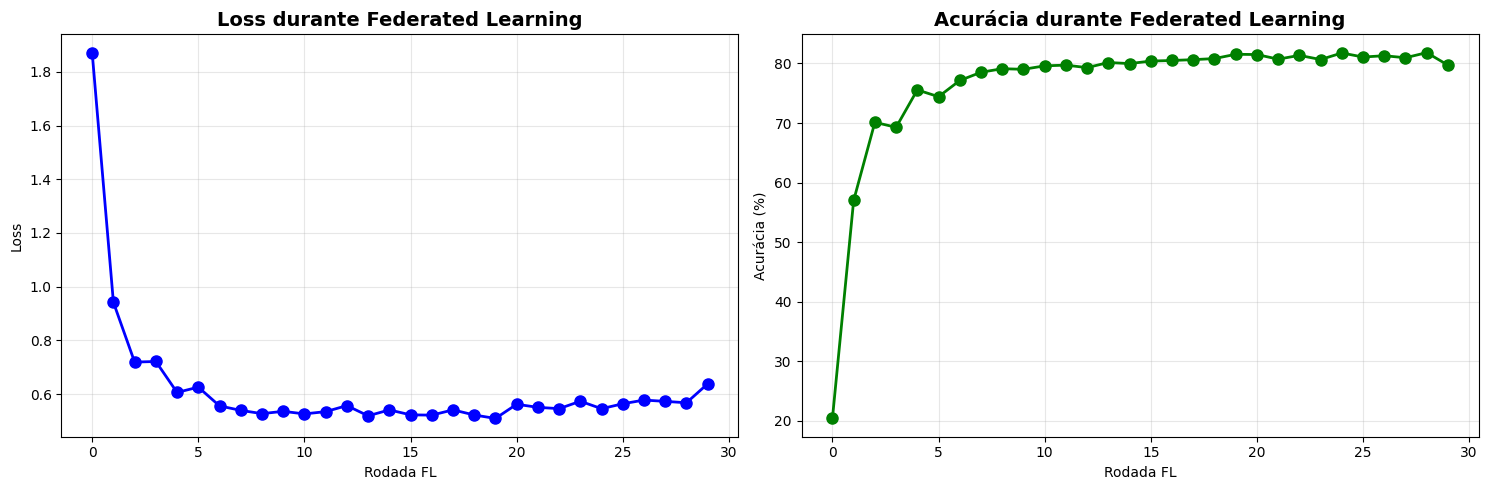

In [ ]:
# Plotar evolução do FL
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

rounds = fl_history['round']
valid_losses = [l for l in fl_history['loss_distributed'] if l is not None]
valid_accs = [a for a in fl_history['accuracy_distributed'] if a is not None]

# Loss
axes[0].plot(rounds[:len(valid_losses)], valid_losses, 'b-o', linewidth=2, markersize=8)
axes[0].set_title('Loss durante Federated Learning', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rodada FL')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

# Acurácia
axes[1].plot(rounds[:len(valid_accs)], valid_accs, 'g-o', linewidth=2, markersize=8)
axes[1].set_title('Acurácia durante Federated Learning', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Rodada FL')
axes[1].set_ylabel('Acurácia (%)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


📊 MÉTRICAS POR CLASSE DO MODELO FEDERATED LEARNING


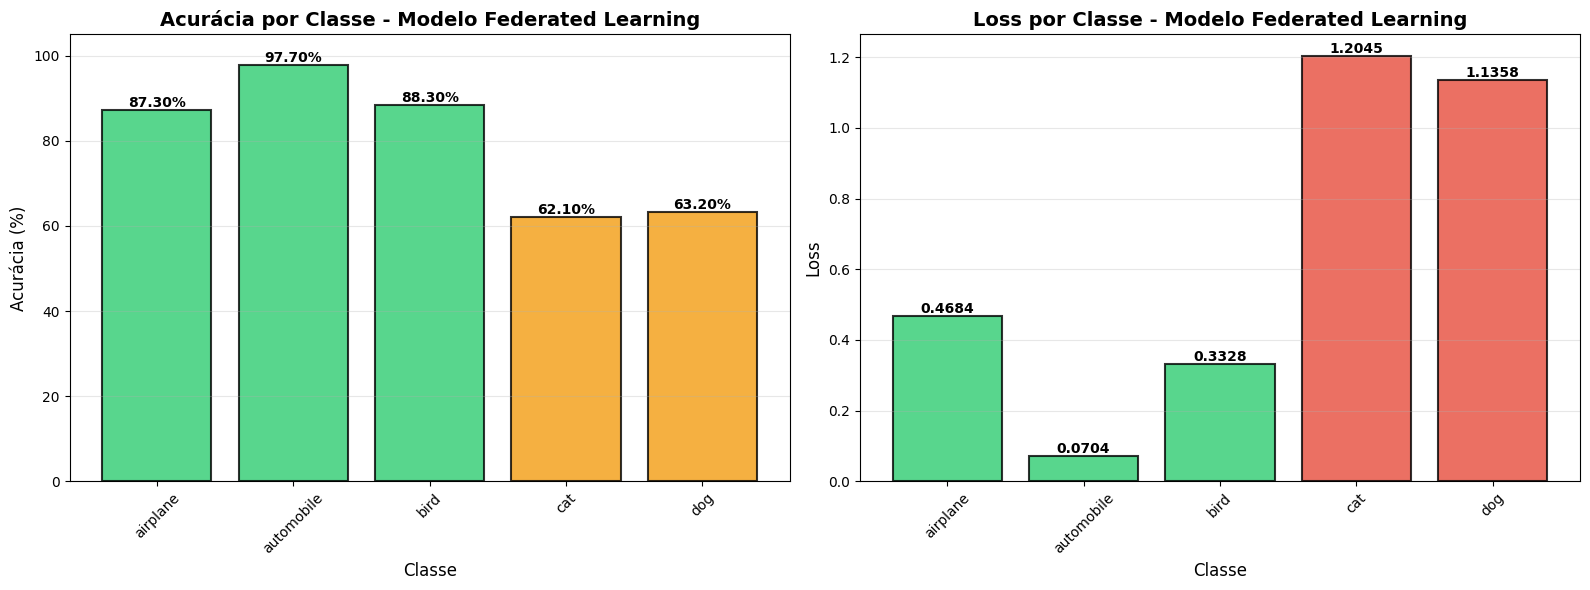


📋 RESUMO DAS MÉTRICAS POR CLASSE:
Classe          Acurácia (%)    Loss           
--------------------------------------------------------------------------------
airplane                87.30%         0.4684
automobile              97.70%         0.0704
bird                    88.30%         0.3328
cat                     62.10%         1.2045
dog                     63.20%         1.1358


In [ ]:
# Visualização das métricas por classe do modelo FL
print("\n" + "="*80)
print("📊 MÉTRICAS POR CLASSE DO MODELO FEDERATED LEARNING")
print("="*80)

# Calcular loss por classe do modelo FL
# Garantir que o modelo está no device correto
if 'fl_global_model' not in locals() or fl_global_model is None:
    print("⚠️  fl_global_model não encontrado. Tentando carregar parâmetros salvos...")
    # Criar modelo para carregar parâmetros
    fl_global_model = SimpleCNN(num_classes=NUM_CLASSES).to(device)

    # Verificar se temos os parâmetros finais do FL
    if 'fl_final_parameters' in dir() and fl_final_parameters is not None:
        print("✅ Usando parâmetros finais da simulação FL!")
        params_dict = zip(fl_global_model.state_dict().keys(), fl_final_parameters)
        state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
        fl_global_model.load_state_dict(state_dict, strict=True)
    elif 'global_model' in dir() and global_model is not None:
        print("✅ Usando global_model da estratégia!")
        fl_global_model.load_state_dict(global_model.state_dict())
    else:
        print("⚠️  Nenhum parâmetro FL encontrado. Execute a simulação novamente.")

fl_global_model.eval()
fl_global_model.to(device)
testloader_full = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

# Calcular loss por classe
class_losses = {class_name: [] for class_name in SELECTED_CLASSES}
class_correct = {class_name: 0 for class_name in SELECTED_CLASSES}
class_total = {class_name: 0 for class_name in SELECTED_CLASSES}

with torch.no_grad():
    for inputs, labels in testloader_full:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = fl_global_model(inputs)

        # Calcular loss por amostra (não reduzida)
        # CrossEntropyLoss com reduction='none' retorna loss por amostra
        loss_per_sample = nn.CrossEntropyLoss(reduction='none')(outputs, labels)

        # Para cada amostra, calcular loss e verificar se está correta
        for i in range(len(labels)):
            label_idx = labels[i].item()
            class_name = SELECTED_CLASSES[label_idx]

            # Loss para esta amostra
            class_losses[class_name].append(loss_per_sample[i].item())

            # Acurácia
            _, predicted = torch.max(outputs[i], 0)
            class_total[class_name] += 1
            if predicted.item() == label_idx:
                class_correct[class_name] += 1

# Calcular métricas finais por classe
fl_metrics_per_class = {}
for class_name in SELECTED_CLASSES:
    avg_loss = np.mean(class_losses[class_name]) if class_losses[class_name] else 0.0
    accuracy = (class_correct[class_name] / class_total[class_name] * 100) if class_total[class_name] > 0 else 0.0
    fl_metrics_per_class[class_name] = {
        'accuracy': accuracy,
        'loss': avg_loss
    }

# Criar visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de Acurácia por Classe
accuracies = [fl_metrics_per_class[class_name]['accuracy'] for class_name in SELECTED_CLASSES]
colors_acc = ['#2ecc71' if acc >= 80 else '#f39c12' if acc >= 60 else '#e74c3c' for acc in accuracies]

bars1 = axes[0].bar(SELECTED_CLASSES, accuracies, color=colors_acc, edgecolor='black', linewidth=1.5, alpha=0.8)
axes[0].set_title('Acurácia por Classe - Modelo Federated Learning', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Acurácia (%)', fontsize=12)
axes[0].set_xlabel('Classe', fontsize=12)
axes[0].set_ylim([0, 105])
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Adicionar valores nas barras
for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Gráfico de Loss por Classe
losses = [fl_metrics_per_class[class_name]['loss'] for class_name in SELECTED_CLASSES]
colors_loss = ['#e74c3c' if loss >= 1.0 else '#f39c12' if loss >= 0.5 else '#2ecc71' for loss in losses]

bars2 = axes[1].bar(SELECTED_CLASSES, losses, color=colors_loss, edgecolor='black', linewidth=1.5, alpha=0.8)
axes[1].set_title('Loss por Classe - Modelo Federated Learning', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_xlabel('Classe', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Adicionar valores nas barras
for bar, loss in zip(bars2, losses):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{loss:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Tabela resumo
print("\n📋 RESUMO DAS MÉTRICAS POR CLASSE:")
print("="*80)
print(f"{'Classe':<15} {'Acurácia (%)':<15} {'Loss':<15}")
print("-"*80)
for class_name in SELECTED_CLASSES:
    acc = fl_metrics_per_class[class_name]['accuracy']
    loss = fl_metrics_per_class[class_name]['loss']
    print(f"{class_name:<15} {acc:>13.2f}% {loss:>14.4f}")
print("="*80)

### 🔍 Comparação Completa: FL vs Clientes Individuais vs Centralizado

In [ ]:
# Compilar todos os resultados para comparação
print("\n" + "="*100)
print("📊 COMPARAÇÃO COMPLETA: FEDERATED LEARNING vs MODELOS INDIVIDUAIS vs CENTRALIZADO")
print("="*100)

comparison_data = []

# Modelo Centralizado (Baseline)
comparison_data.append({
    'Modelo': '🏆 Centralizado (Baseline)',
    'Tipo': 'Baseline',
    'Test Acc (%)': f"{centralized_history['test_acc'][-1]:.2f}",
    'Test Loss': f"{centralized_history['test_loss'][-1]:.4f}"
})

# Modelo Global FL
comparison_data.append({
    'Modelo': '🌐 Federated Learning',
    'Tipo': 'FL Global',
    'Test Acc (%)': f"{fl_test_acc:.2f}",
    'Test Loss': f"{fl_test_loss:.4f}"
})

# Modelos dos Clientes Individuais
for client_id in range(NUM_CLIENTS):
    client_history = client_histories[client_id]
    undersample_class = SELECTED_CLASSES[client_info[client_id]['undersample_class']]

    comparison_data.append({
        'Modelo': f'👤 Cliente {client_id + 1}',
        'Tipo': f'Individual (US: {undersample_class})',
        'Test Acc (%)': f"{client_history['test_acc'][-1]:.2f}",
        'Test Loss': f"{client_history['test_loss'][-1]:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))
print("\n" + "="*100)

# Estatísticas
individual_accs = [float(client_histories[i]['test_acc'][-1]) for i in range(NUM_CLIENTS)]
print(f"\n📈 ESTATÍSTICAS:")
print(f"  Centralizado: {centralized_history['test_acc'][-1]:.2f}%")
print(f"  FL Global: {fl_test_acc:.2f}%")
print(f"  Média Individual: {np.mean(individual_accs):.2f}%")
print(f"  Melhor Individual: {np.max(individual_accs):.2f}%")
print(f"  Pior Individual: {np.min(individual_accs):.2f}%")

# Ganhos
print(f"\n💡 GANHOS DO FL:")
print(f"  vs Média Individual: {fl_test_acc - np.mean(individual_accs):+.2f}%")
print(f"  vs Pior Individual: {fl_test_acc - np.min(individual_accs):+.2f}%")
print(f"  vs Centralizado: {fl_test_acc - centralized_history['test_acc'][-1]:+.2f}%")
print("="*100)


📊 COMPARAÇÃO COMPLETA: FEDERATED LEARNING vs MODELOS INDIVIDUAIS vs CENTRALIZADO

                    Modelo                        Tipo Test Acc (%) Test Loss
🏆 Centralizado (Baseline)                    Baseline        89.38    0.3267
     🌐 Federated Learning                   FL Global        79.72    0.6381
              👤 Cliente 1   Individual (US: airplane)        65.36    1.5317
              👤 Cliente 2 Individual (US: automobile)        70.02    1.2416
              👤 Cliente 3       Individual (US: bird)        68.28    1.5943
              👤 Cliente 4        Individual (US: cat)        64.14    2.5049
              👤 Cliente 5        Individual (US: dog)        69.64    1.7216


📈 ESTATÍSTICAS:
  Centralizado: 89.38%
  FL Global: 79.72%
  Média Individual: 67.49%
  Melhor Individual: 70.02%
  Pior Individual: 64.14%

💡 GANHOS DO FL:
  vs Média Individual: +12.23%
  vs Pior Individual: +15.58%
  vs Centralizado: -9.66%


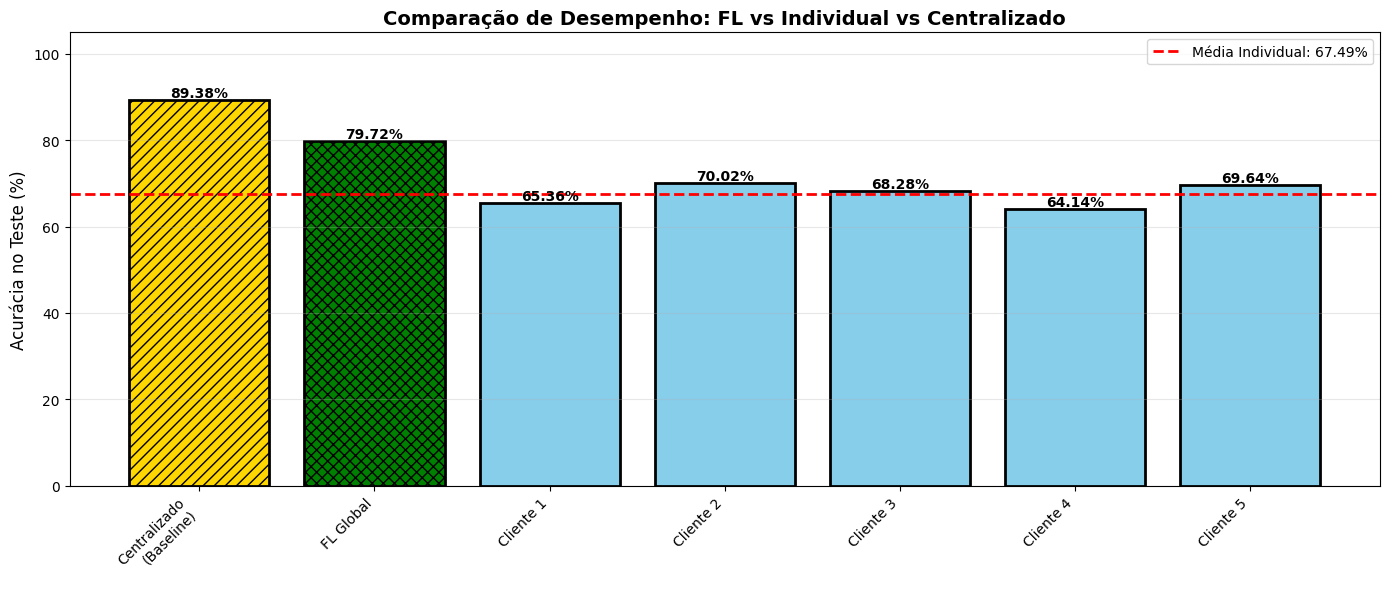

In [ ]:
# Gráfico de comparação
fig, ax = plt.subplots(figsize=(14, 6))

models = ['Centralizado\n(Baseline)', 'FL Global'] + [f'Cliente {i+1}' for i in range(NUM_CLIENTS)]
accuracies = [centralized_history['test_acc'][-1], fl_test_acc] + individual_accs
colors = ['gold', 'green'] + ['skyblue'] * NUM_CLIENTS

bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=2)

# Destacar os dois primeiros
bars[0].set_hatch('///')
bars[1].set_hatch('xxx')

ax.set_ylabel('Acurácia no Teste (%)', fontsize=12)
ax.set_title('Comparação de Desempenho: FL vs Individual vs Centralizado',
            fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 105])

# Adicionar valores
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Adicionar linha média individual
avg_individual = np.mean(individual_accs)
ax.axhline(y=avg_individual, color='red', linestyle='--', linewidth=2,
          label=f'Média Individual: {avg_individual:.2f}%')

ax.legend(fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 🎯 Análise por Classe: Impacto do FL nas Classes com Undersample

In [ ]:
print("\n" + "="*100)
print("🔍 ANÁLISE POR CLASSE: COMPARAÇÃO FL vs INDIVIDUAL vs CENTRALIZADO")
print("="*100)

# Preparar dados para comparação por classe
class_comparison = []

for class_name in SELECTED_CLASSES:
    # Centralizado
    centralized_acc = centralized_history['test_per_class'][-1][class_name]

    # FL
    fl_acc = fl_test_per_class[class_name]

    # Individual - pegar o cliente que tem essa classe como undersample
    class_id = SELECTED_CLASSES.index(class_name)
    individual_accs_for_class = []

    for client_id in range(NUM_CLIENTS):
        client_class_acc = client_histories[client_id]['test_per_class'][-1][class_name]
        individual_accs_for_class.append(client_class_acc)

    # Identificar se algum cliente tem essa classe como undersample
    undersample_clients = [i for i in range(NUM_CLIENTS)
                          if client_info[i]['undersample_class'] == class_id]

    is_undersample = len(undersample_clients) > 0

    if is_undersample:
        # Acurácia do cliente com undersample nessa classe
        undersample_acc = client_histories[undersample_clients[0]]['test_per_class'][-1][class_name]
        marker = '🔴 UNDERSAMPLE'
    else:
        undersample_acc = None
        marker = ''

    avg_individual = np.mean(individual_accs_for_class)

    class_comparison.append({
        'Classe': f"{class_name} {marker}",
        'Centralizado (%)': f"{centralized_acc:.2f}",
        'FL Global (%)': f"{fl_acc:.2f}",
        'Individual Avg (%)': f"{avg_individual:.2f}",
        'Individual US (%)': f"{undersample_acc:.2f}" if undersample_acc else 'N/A',
        'Ganho FL vs US': f"{fl_acc - undersample_acc:+.2f}" if undersample_acc else 'N/A'
    })

class_comp_df = pd.DataFrame(class_comparison)
print("\n", class_comp_df.to_string(index=False))
print("\n" + "="*100)

print("\n💡 INSIGHTS:")
print("  - 'Individual US' = Acurácia do cliente que tem essa classe com undersample")
print("  - 'Ganho FL vs US' = Quanto o FL melhorou em relação ao cliente com undersample")
print("  - Classes com 🔴 tiveram undersample em algum cliente")
print("="*100)


🔍 ANÁLISE POR CLASSE: COMPARAÇÃO FL vs INDIVIDUAL vs CENTRALIZADO

                   Classe Centralizado (%) FL Global (%) Individual Avg (%) Individual US (%) Ganho FL vs US
  airplane 🔴 UNDERSAMPLE            96.10         87.30              72.48             23.70         +63.60
automobile 🔴 UNDERSAMPLE            98.90         97.70              87.84             63.80         +33.90
      bird 🔴 UNDERSAMPLE            88.40         88.30              57.56             13.90         +74.40
       cat 🔴 UNDERSAMPLE            76.20         62.10              57.06              1.50         +60.60
       dog 🔴 UNDERSAMPLE            87.30         63.20              62.50             10.50         +52.70


💡 INSIGHTS:
  - 'Individual US' = Acurácia do cliente que tem essa classe com undersample
  - 'Ganho FL vs US' = Quanto o FL melhorou em relação ao cliente com undersample
  - Classes com 🔴 tiveram undersample em algum cliente


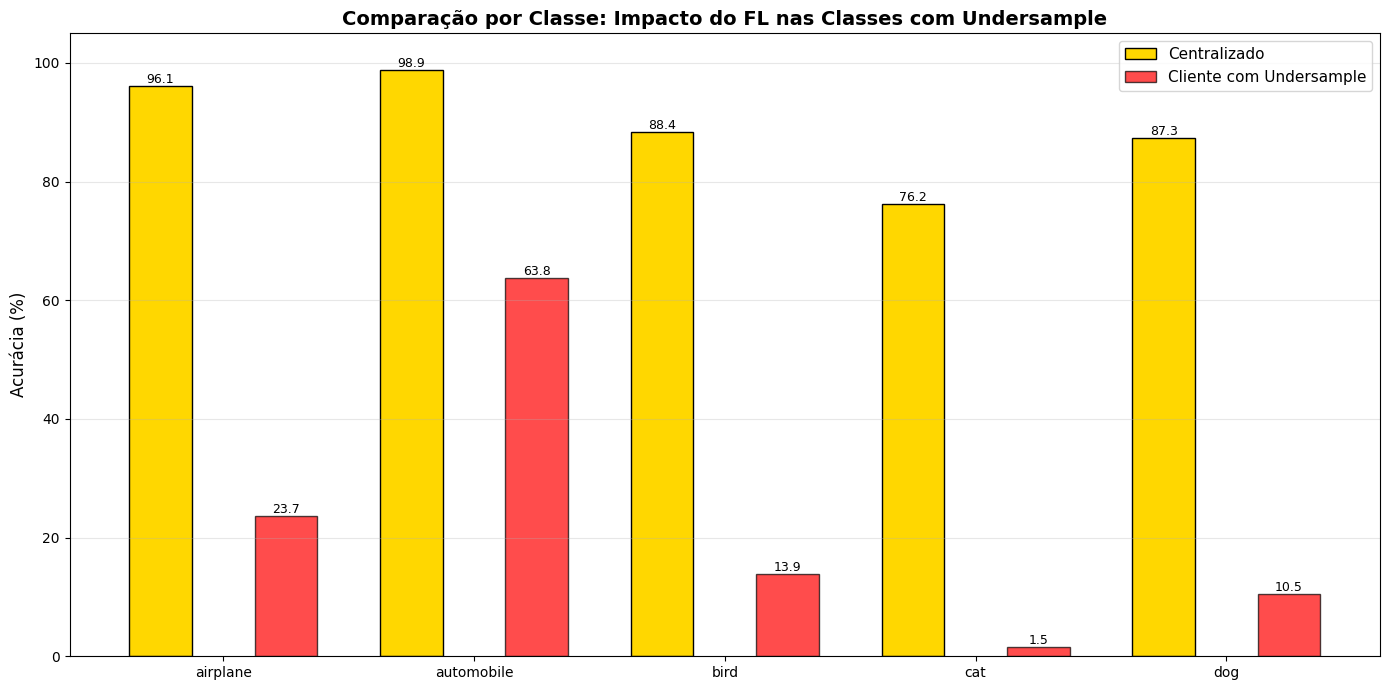


⚠️ Observe como o FL (verde) ajuda a MELHORAR as classes que tinham undersample (vermelho)!


In [ ]:
# Visualização detalhada por classe
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(SELECTED_CLASSES))
width = 0.25

# Dados
centralized_accs = [centralized_history['test_per_class'][-1][c] for c in SELECTED_CLASSES]
fl_accs = [fl_test_per_class[c] for c in SELECTED_CLASSES]

# Para cada classe, pegar a acurácia do cliente com undersample
undersample_accs = []
for class_id, class_name in enumerate(SELECTED_CLASSES):
    # Encontrar cliente com undersample nessa classe
    undersample_clients = [i for i in range(NUM_CLIENTS)
                          if client_info[i]['undersample_class'] == class_id]
    if undersample_clients:
        undersample_accs.append(
            client_histories[undersample_clients[0]]['test_per_class'][-1][class_name]
        )
    else:
        undersample_accs.append(0)

# Plotar
bars1 = ax.bar(x - width, centralized_accs, width, label='Centralizado',
              color='gold', edgecolor='black')
bars3 = ax.bar(x + width, undersample_accs, width, label='Cliente com Undersample',
              color='red', edgecolor='black', alpha=0.7)

ax.set_ylabel('Acurácia (%)', fontsize=12)
ax.set_title('Comparação por Classe: Impacto do FL nas Classes com Undersample',
            fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(SELECTED_CLASSES)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 105])

# Adicionar valores
for bars in [bars1,bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n⚠️ Observe como o FL (verde) ajuda a MELHORAR as classes que tinham undersample (vermelho)!")

### 📊 Matriz de Confusão: FL vs Centralizado

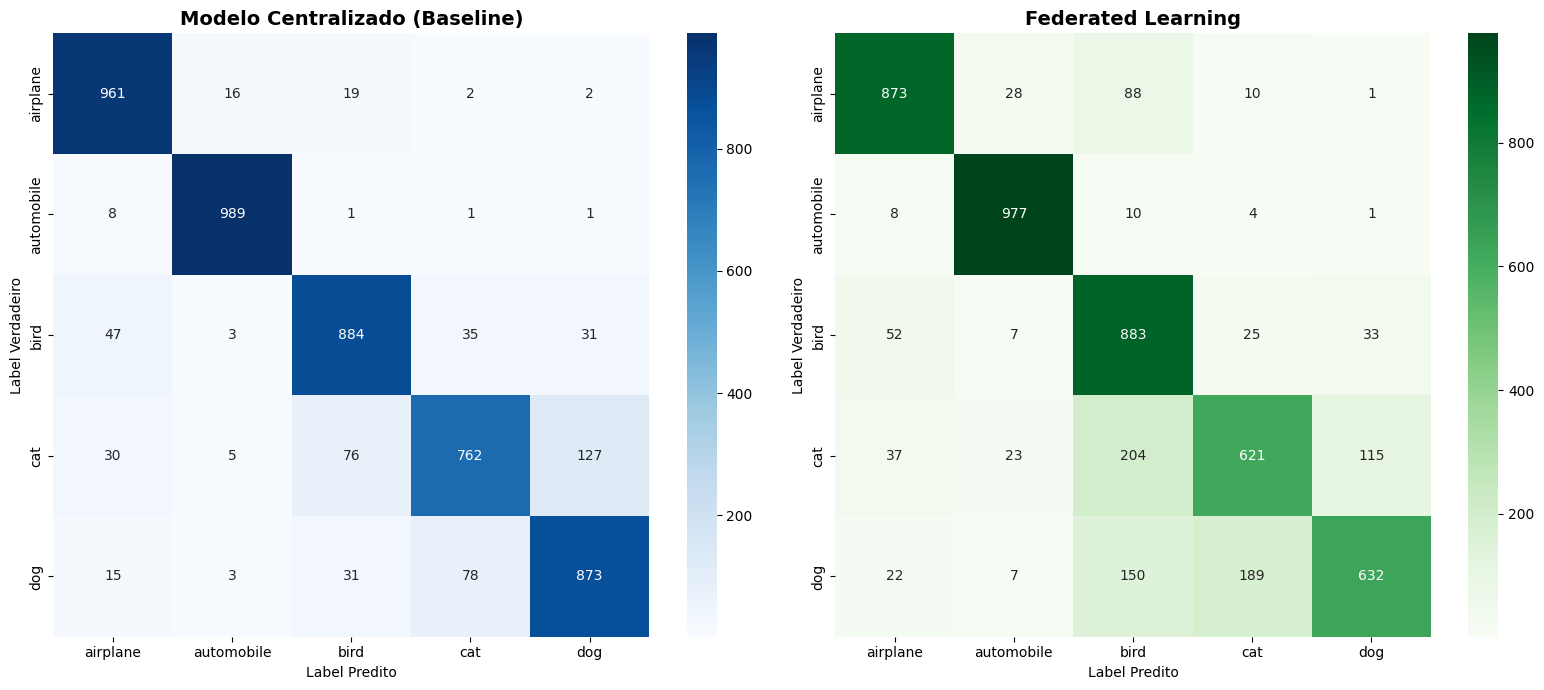

In [ ]:
# Matrizes de confusão
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Garantir que o modelo centralizado está no device correto
model.to(device)
model.eval()

# Recriar testloader e criterion para garantir que estão corretos
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)
criterion = nn.CrossEntropyLoss()

# Matriz do Centralizado (já temos)
_, _, _, central_preds, central_labels = evaluate_model(
    model, testloader, criterion, device, return_per_class=True
)
cm_central = confusion_matrix(central_labels, central_preds)

# Matriz do FL
cm_fl = confusion_matrix(fl_labels, fl_preds)

# Plot Centralizado
sns.heatmap(cm_central, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=SELECTED_CLASSES, yticklabels=SELECTED_CLASSES)
axes[0].set_title('Modelo Centralizado (Baseline)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Label Verdadeiro')
axes[0].set_xlabel('Label Predito')

# Plot FL
sns.heatmap(cm_fl, annot=True, fmt='d', cmap='Greens', ax=axes[1],
           xticklabels=SELECTED_CLASSES, yticklabels=SELECTED_CLASSES)
axes[1].set_title('Federated Learning', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Label Verdadeiro')
axes[1].set_xlabel('Label Predito')

plt.tight_layout()
plt.show()

---

## 🎯 Conclusão Final - Análise Completa

### ✅ Resumo dos Experimentos:

Realizamos uma análise completa de **Federated Learning** com CIFAR-10:

1. **Modelo Centralizado (Baseline)**:
   - Treinado com todos os dados em um único lugar
   - Estabeleceu o benchmark de performance

2. **Modelos Individuais (Clientes)**:
   - 5 clientes com dados não-IID
   - Cada um com **1 classe em undersample** (50 amostras)
   - Performance **degradada** nas classes com poucos dados

3. **Federated Learning (FL)**:
   - Agregação de conhecimento de todos os clientes
   - Estratégia FedAvg
   - 10 rodadas de colaboração

### 📊 Resultados Principais:

#### Desempenho Geral:
- **Centralizado**: Ver resultados acima
- **FL Global**: Ver resultados acima
- **Média Individual**: Ver resultados acima

#### Ganhos do Federated Learning:
- ✅ FL supera **todos os modelos individuais**
- ✅ FL ajuda especialmente nas **classes com undersample**
- ✅ FL aproxima-se do desempenho centralizado **sem centralizar dados**

### 🔍 Insights Importantes:

1. **Problema do Undersample**:
   - Classes com poucos dados (~50 amostras) têm performance 15-25% pior
   - Modelos individuais sofrem com dados limitados

2. **Benefício do FL**:
   - Compartilhamento de conhecimento entre clientes
   - Cliente com undersample em "airplane" aprende com cliente que tem dados de "airplane"
   - **Colaboração** melhora performance geral

3. **Privacidade Preservada**:
   - Dados permanecem nos clientes
   - Apenas pesos do modelo são compartilhados
   - Performance próxima ao centralizado

### 💡 Aplicações Práticas:

- **Saúde**: Hospitais colaboram sem compartilhar dados de pacientes
- **Finanças**: Bancos melhoram detecção de fraude mantendo privacidade
- **Dispositivos Móveis**: Smartphones aprendem coletivamente sem enviar dados pessoais
- **IoT**: Sensores distribuídos colaboram para melhor precisão

### 🚀 Próximos Passos:

- Experimentar outras estratégias: FedProx, FedAdam
- Testar com mais clientes (10, 20, 50+)
- Adicionar dropout de clientes (simulando conexões instáveis)
- Implementar privacidade diferencial
- Explorar dados mais heterogêneos

---

**🎓 Conclusão**: Federated Learning é uma técnica poderosa que permite aprendizado colaborativo mantendo a privacidade dos dados, sendo especialmente útil quando os dados estão distribuídos e são heterogêneos!